<a href="https://colab.research.google.com/github/parth2601/branchynet/blob/master/final_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Neural Networks with Early Exits (MNIST)



This notebook implements and compares static and dynamic neural networks with early exits using the MNIST dataset. We'll implement:



1. Static networks (LeNet, AlexNet, ResNet)

2. Dynamic networks with early exits (BranchyNet approach)

3. Comparative analysis of performance and efficiency



## Table of Contents

1. Setup and Data Loading

2. Model Implementations

3. Training and Evaluation Functions

4. Experiments and Analysis

5. Visualization and Comparison

## 1. Setup and Data Loading

In [ ]:
# Imports and Data Loading



import torch

import torch.nn as nn

import torch.optim as optim

import torch.nn.functional as F

from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import time

import numpy as np



# Set random seed for reproducibility

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Data loading and preprocessing

transform = transforms.Compose([

    transforms.Resize(32),

    transforms.ToTensor(),

    transforms.Normalize((0.1307,), (0.3081,))

])



train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

test_dataset = datasets.MNIST('./data', train=False, transform=transform)



train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=2)

## 2. Model Implementations

In [ ]:
# Static LeNet

class StaticLeNet(nn.Module):

    def __init__(self):

        super(StaticLeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)  # 32x32 -> 28x28

        self.conv2 = nn.Conv2d(6, 16, 5)  # 14x14 -> 10x10

        self.fc1 = nn.Linear(16*5*5, 120)  # Adjusted for input size 32x32

        self.fc2 = nn.Linear(120, 84)

        self.fc3 = nn.Linear(84, 10)



    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), 2)  # 32x32 -> 28x28 -> 14x14

        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # 14x14 -> 10x10 -> 5x5

        x = x.view(-1, 16*5*5)

        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))

        x = self.fc3(x)

        return x



# Dynamic LeNet with Early Exits

class DynamicLeNet(nn.Module):
    def __init__(self, exit_thresholds=[0.5, 0.7]):
        super(DynamicLeNet, self).__init__()
        self.exit_thresholds = exit_thresholds

        # Main network components
        self.conv1 = nn.Conv2d(1, 6, 5)  # 32x32 -> 28x28
        self.conv2 = nn.Conv2d(6, 16, 5)  # 14x14 -> 10x10
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Early exit 1
        self.exit1 = nn.Sequential(
            nn.AvgPool2d(14),  # 14x14 -> 1x1
            nn.Flatten(),
            nn.Linear(6*1*1, 10)
        )

        # Early exit 2
        self.exit2 = nn.Sequential(
            nn.AvgPool2d(5),  # 5x5 -> 1x1
            nn.Flatten(),
            nn.Linear(16*1*1, 10)
        )

    def forward(self, x, training=False):
        # First layer
        x1 = F.relu(self.conv1(x))
        x1_pool = F.max_pool2d(x1, 2)

        # Early exit 1
        exit1_out = self.exit1(x1_pool)

        # Second layer
        x2 = F.relu(self.conv2(x1_pool))
        x2_pool = F.max_pool2d(x2, 2)

        # Early exit 2
        exit2_out = self.exit2(x2_pool)

        # Final exit
        x = x2_pool.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        if training:
            return x, exit1_out, exit2_out
        else:
            # Use early exits during inference
            batch_size = x.shape[0]
            exit1_confidence = F.softmax(exit1_out, dim=1).max(1)[0]
            exit2_confidence = F.softmax(exit2_out, dim=1).max(1)[0]

            # Initialize outputs and exit points for the batch
            outputs = []
            exit_points = []

            # Process each sample in the batch
            for i in range(batch_size):
                if exit1_confidence[i] >= self.exit_thresholds[0]:
                    outputs.append(exit1_out[i:i+1])
                    exit_points.append(1)
                elif exit2_confidence[i] >= self.exit_thresholds[1]:
                    outputs.append(exit2_out[i:i+1])
                    exit_points.append(2)
                else:
                    outputs.append(x[i:i+1])
                    exit_points.append(3)

            # Stack outputs and convert exit points to tensor
            outputs = torch.cat(outputs, dim=0)
            exit_points = torch.tensor(exit_points, device=x.device)

            return outputs, exit_points


# Static AlexNet

class StaticAlexNet(nn.Module):

    def __init__(self, num_classes=10):

        super(StaticAlexNet, self).__init__()

        self.features = nn.Sequential(

            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # 32x32

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16

            nn.Conv2d(64, 192, kernel_size=3, padding=1),  # 16x16

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8

            nn.Conv2d(192, 384, kernel_size=3, padding=1),  # 8x8

            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 8x8

            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 8x8

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4

        )

        self.classifier = nn.Sequential(

            nn.Dropout(),

            nn.Linear(256 * 4 * 4, 4096),

            nn.ReLU(inplace=True),

            nn.Dropout(),

            nn.Linear(4096, 4096),

            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),

        )



    def forward(self, x):

        x = self.features(x)

        x = x.view(-1, 256 * 4 * 4)

        x = self.classifier(x)

        return x



# Dynamic AlexNet

class DynamicAlexNet(StaticAlexNet):
    def __init__(self, num_classes=10, exit_thresholds=[0.5, 0.7]):
        super(DynamicAlexNet, self).__init__(num_classes)
        self.exit_thresholds = exit_thresholds

        # Early exit 1 after first MaxPool
        self.exit1 = nn.Sequential(
            nn.AvgPool2d(16),  # 16x16 -> 1x1
            nn.Flatten(),
            nn.Linear(64 * 1 * 1, num_classes)
        )

        # Early exit 2 after second MaxPool
        self.exit2 = nn.Sequential(
            nn.AvgPool2d(8),  # 8x8 -> 1x1
            nn.Flatten(),
            nn.Linear(192 * 1 * 1, num_classes)
        )

    def forward(self, x, training=False):
        # Features up to first MaxPool
        x1 = self.features[:3](x)

        # Early exit 1
        exit1_out = self.exit1(x1)

        # Features up to second MaxPool
        x2 = self.features[3:6](x1)

        # Early exit 2
        exit2_out = self.exit2(x2)

        # Remaining features
        x3 = self.features[6:](x2)
        x3 = x3.view(-1, 256 * 4 * 4)
        x = self.classifier(x3)

        if training:
            return x, exit1_out, exit2_out
        else:
            batch_size = x.shape[0]
            exit1_confidence = F.softmax(exit1_out, dim=1).max(1)[0]
            exit2_confidence = F.softmax(exit2_out, dim=1).max(1)[0]

            outputs = []
            exit_points = []

            for i in range(batch_size):
                if exit1_confidence[i] >= self.exit_thresholds[0]:
                    outputs.append(exit1_out[i:i+1])
                    exit_points.append(1)
                elif exit2_confidence[i] >= self.exit_thresholds[1]:
                    outputs.append(exit2_out[i:i+1])
                    exit_points.append(2)
                else:
                    outputs.append(x[i:i+1])
                    exit_points.append(3)

            outputs = torch.cat(outputs, dim=0)
            exit_points = torch.tensor(exit_points, device=x.device)

            return outputs, exit_points

# Static ResNet

from torchvision.models.resnet import BasicBlock



class StaticResNet(nn.Module):

    def __init__(self, num_classes=10):

        super(StaticResNet, self).__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,

                               bias=False)  # 32x32 -> 32x32

        self.bn1 = nn.BatchNorm2d(64)

        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(BasicBlock, 64, 2)

        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)

        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)

        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)



    def _make_layer(self, block, planes, blocks, stride=1):

        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:

            downsample = nn.Sequential(

                nn.Conv2d(self.inplanes, planes * block.expansion,

                          kernel_size=1, stride=stride, bias=False),

                nn.BatchNorm2d(planes * block.expansion),

            )



        layers = []

        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes * block.expansion

        for _ in range(1, blocks):

            layers.append(block(self.inplanes, planes))



        return nn.Sequential(*layers)



    def forward(self, x):

        x = self.conv1(x)

        x = self.bn1(x)

        x = self.relu(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x



# Dynamic ResNet

class DynamicResNet(StaticResNet):
    def __init__(self, num_classes=10, exit_thresholds=[0.5, 0.7]):
        super(DynamicResNet, self).__init__(num_classes)
        self.exit_thresholds = exit_thresholds

        # Early exit after layer1
        self.exit1 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

        # Early exit after layer2
        self.exit2 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x1 = self.layer1(x)

        # Early exit after layer1
        exit1_out = self.exit1(x1)

        x2 = self.layer2(x1)

        # Early exit after layer2
        exit2_out = self.exit2(x2)

        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x = self.avgpool(x4)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        if training:
            return x, exit1_out, exit2_out
        else:
            # Use early exits during inference
            batch_size = x.shape[0]
            exit1_confidence = F.softmax(exit1_out, dim=1).max(1)[0]
            exit2_confidence = F.softmax(exit2_out, dim=1).max(1)[0]

            outputs = []
            exit_points = []

            # Process each sample in the batch
            for i in range(batch_size):
                if exit1_confidence[i] >= self.exit_thresholds[0]:
                    outputs.append(exit1_out[i:i+1])
                    exit_points.append(1)
                elif exit2_confidence[i] >= self.exit_thresholds[1]:
                    outputs.append(exit2_out[i:i+1])
                    exit_points.append(2)
                else:
                    outputs.append(x[i:i+1])
                    exit_points.append(3)

            # Stack outputs and convert exit points to tensor
            outputs = torch.cat(outputs, dim=0)
            exit_points = torch.tensor(exit_points, device=x.device)

            return outputs, exit_points

## 3. Training and Evaluation Functions

In [ ]:
# Training function for static models

def train_static_model(model, train_loader, epochs=10):

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters())



    train_losses = []

    train_times = []



    for epoch in range(epochs):

        model.train()

        epoch_loss = 0

        start_time = time.time()



        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, target)

            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()



        epoch_time = time.time() - start_time

        train_times.append(epoch_time)

        train_losses.append(epoch_loss/len(train_loader))



        print(f'Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Time = {epoch_time:.2f}s')



    return train_losses, train_times



# Training function for dynamic models

def train_dynamic_model(model, train_loader, epochs=10):

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters())



    train_losses = []

    train_times = []



    for epoch in range(epochs):

        model.train()

        epoch_loss = 0

        start_time = time.time()



        for batch_idx, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(data, training=True)



            if isinstance(outputs, tuple):

                main_output = outputs[0]

                exit_outputs = outputs[1:]

            else:

                main_output = outputs

                exit_outputs = []



            loss_main = criterion(main_output, target)

            loss_exits = 0

            for exit_output in exit_outputs:

                loss_exits += criterion(exit_output, target)

            total_loss = loss_main + loss_exits



            total_loss.backward()

            optimizer.step()

            epoch_loss += total_loss.item()



        epoch_time = time.time() - start_time

        train_times.append(epoch_time)

        train_losses.append(epoch_loss / len(train_loader))



        print(f'Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Time = {epoch_time:.2f}s')



    return train_losses, train_times



# Evaluation function for static models

def evaluate_static_model(model, test_loader):

    model.eval()

    correct = 0

    total = 0

    inference_times = []



    with torch.no_grad():

        for data, target in test_loader:

            data, target = data.to(device), target.to(device)

            start_time = time.time()

            output = model(data)

            inference_time = time.time() - start_time

            inference_times.append(inference_time)



            _, predicted = torch.max(output.data, 1)

            total += target.size(0)

            correct += (predicted == target).sum().item()



    accuracy = 100 * correct / total

    avg_inference_time = sum(inference_times) / len(inference_times)



    return accuracy, avg_inference_time



# Evaluation function for dynamic models

def evaluate_dynamic_model(model, test_loader):
    model.eval()
    exit_counts = {1: 0, 2: 0, 3: 0}
    exit_correct = {1: 0, 2: 0, 3: 0}
    inference_times = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            start_time = time.time()
            output, exit_points = model(data)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            _, predicted = torch.max(output.data, 1)

            # Process each sample in the batch
            for i in range(len(exit_points)):
                exit_point = int(exit_points[i].item())  # Convert tensor to integer
                exit_counts[exit_point] += 1
                exit_correct[exit_point] += (predicted[i] == target[i]).item()

    total_samples = sum(exit_counts.values())
    overall_accuracy = 100 * sum(exit_correct.values()) / total_samples
    avg_inference_time = sum(inference_times) / len(inference_times)

    exit_accuracies = {
        exit_point: 100 * exit_correct[exit_point] / exit_counts[exit_point]
        if exit_counts[exit_point] > 0 else None
        for exit_point in exit_counts.keys()
    }

    return overall_accuracy, avg_inference_time, exit_counts, exit_accuracies

## 4. Experiments and Analysis

In [ ]:
# LeNet Models

static_lenet = StaticLeNet()

dynamic_lenet = DynamicLeNet()



print("Training Static LeNet...")

static_losses_lenet, static_times_lenet = train_static_model(static_lenet, train_loader)

static_accuracy_lenet, static_inference_time_lenet = evaluate_static_model(static_lenet, test_loader)

print(f"Static LeNet - Accuracy: {static_accuracy_lenet:.2f}%, Avg Inference Time: {static_inference_time_lenet*1000:.2f}ms")



print("\nTraining Dynamic LeNet...")

dynamic_losses_lenet, dynamic_times_lenet = train_dynamic_model(dynamic_lenet, train_loader)

dynamic_accuracy_lenet, dynamic_inference_time_lenet, exit_counts_lenet, exit_accuracies_lenet = evaluate_dynamic_model(dynamic_lenet, test_loader)

print(f"Dynamic LeNet - Accuracy: {dynamic_accuracy_lenet:.2f}%, Avg Inference Time: {dynamic_inference_time_lenet*1000:.2f}ms")

print(f"Exit Counts: {exit_counts_lenet}")

print(f"Exit Accuracies: {exit_accuracies_lenet}")



# AlexNet Models

static_alexnet = StaticAlexNet()

dynamic_alexnet = DynamicAlexNet()



print("\nTraining Static AlexNet...")

static_losses_alexnet, static_times_alexnet = train_static_model(static_alexnet, train_loader)

static_accuracy_alexnet, static_inference_time_alexnet = evaluate_static_model(static_alexnet, test_loader)

print(f"Static AlexNet - Accuracy: {static_accuracy_alexnet:.2f}%, Avg Inference Time: {static_inference_time_alexnet*1000:.2f}ms")



print("\nTraining Dynamic AlexNet...")

dynamic_losses_alexnet, dynamic_times_alexnet = train_dynamic_model(dynamic_alexnet, train_loader)

dynamic_accuracy_alexnet, dynamic_inference_time_alexnet, exit_counts_alexnet, exit_accuracies_alexnet = evaluate_dynamic_model(dynamic_alexnet, test_loader)

print(f"Dynamic AlexNet - Accuracy: {dynamic_accuracy_alexnet:.2f}%, Avg Inference Time: {dynamic_inference_time_alexnet*1000:.2f}ms")

print(f"Exit Counts: {exit_counts_alexnet}")

print(f"Exit Accuracies: {exit_accuracies_alexnet}")



# ResNet Models

static_resnet = StaticResNet()

dynamic_resnet = DynamicResNet()



print("\nTraining Static ResNet...")

static_losses_resnet, static_times_resnet = train_static_model(static_resnet, train_loader)

static_accuracy_resnet, static_inference_time_resnet = evaluate_static_model(static_resnet, test_loader)

print(f"Static ResNet - Accuracy: {static_accuracy_resnet:.2f}%, Avg Inference Time: {static_inference_time_resnet*1000:.2f}ms")



print("\nTraining Dynamic ResNet...")

dynamic_losses_resnet, dynamic_times_resnet = train_dynamic_model(dynamic_resnet, train_loader)

dynamic_accuracy_resnet, dynamic_inference_time_resnet, exit_counts_resnet, exit_accuracies_resnet = evaluate_dynamic_model(dynamic_resnet, test_loader)

print(f"Dynamic ResNet - Accuracy: {dynamic_accuracy_resnet:.2f}%, Avg Inference Time: {dynamic_inference_time_resnet*1000:.2f}ms")

print(f"Exit Counts: {exit_counts_resnet}")

print(f"Exit Accuracies: {exit_accuracies_resnet}")

Training Static LeNet...
Epoch 1: Loss = 0.2145, Time = 10.99s
Epoch 2: Loss = 0.0626, Time = 11.19s
Epoch 3: Loss = 0.0458, Time = 10.91s
Epoch 4: Loss = 0.0350, Time = 11.00s
Epoch 5: Loss = 0.0299, Time = 11.23s
Epoch 6: Loss = 0.0261, Time = 10.96s
Epoch 7: Loss = 0.0199, Time = 11.02s
Epoch 8: Loss = 0.0180, Time = 11.20s
Epoch 9: Loss = 0.0164, Time = 10.77s
Epoch 10: Loss = 0.0142, Time = 10.97s
Static LeNet - Accuracy: 98.99%, Avg Inference Time: 0.98ms

Training Dynamic LeNet...
Epoch 1: Loss = 3.6663, Time = 11.32s
Epoch 2: Loss = 2.5457, Time = 11.18s
Epoch 3: Loss = 2.2102, Time = 11.20s
Epoch 4: Loss = 2.0054, Time = 11.34s
Epoch 5: Loss = 1.8802, Time = 11.27s
Epoch 6: Loss = 1.7983, Time = 11.21s
Epoch 7: Loss = 1.7389, Time = 11.19s
Epoch 8: Loss = 1.6892, Time = 11.06s
Epoch 9: Loss = 1.6525, Time = 11.38s
Epoch 10: Loss = 1.6089, Time = 11.45s
Dynamic LeNet - Accuracy: 96.85%, Avg Inference Time: 100.46ms
Exit Counts: {1: 1451, 2: 8115, 3: 434}
Exit Accuracies: {1: 91

## 5. Visualization and Comparison

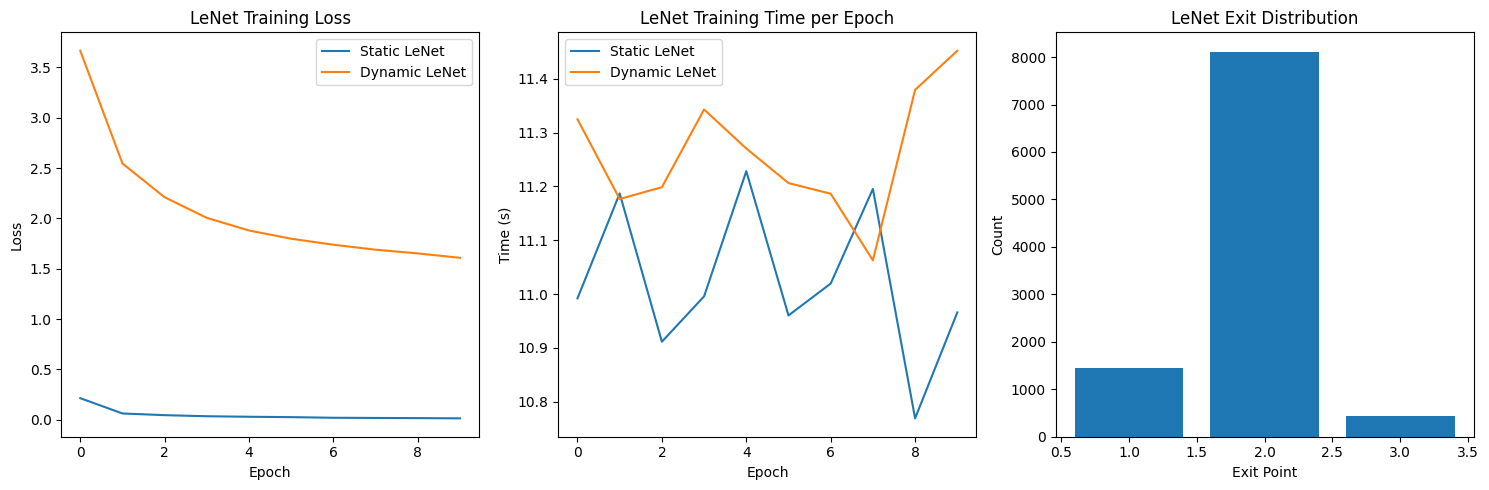

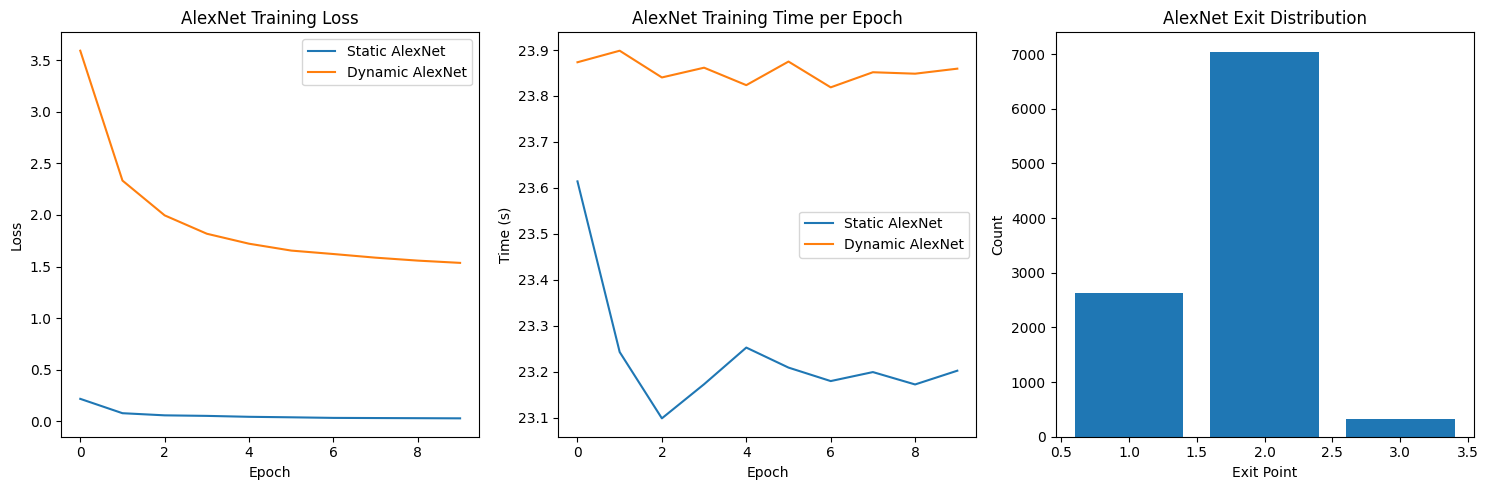

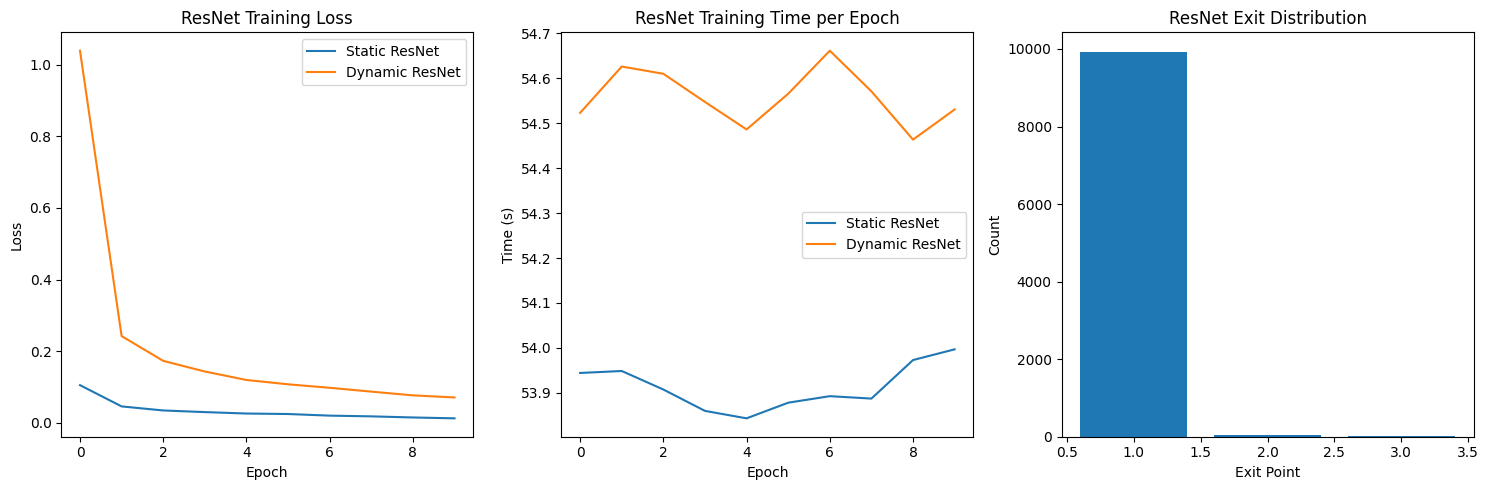

In [ ]:
# Visualization of LeNet Results

plt.figure(figsize=(15, 5))



# Plot training losses

plt.subplot(1, 3, 1)

plt.plot(static_losses_lenet, label='Static LeNet')

plt.plot(dynamic_losses_lenet, label='Dynamic LeNet')

plt.title('LeNet Training Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()



# Plot training times

plt.subplot(1, 3, 2)

plt.plot(static_times_lenet, label='Static LeNet')

plt.plot(dynamic_times_lenet, label='Dynamic LeNet')

plt.title('LeNet Training Time per Epoch')

plt.xlabel('Epoch')

plt.ylabel('Time (s)')

plt.legend()



# Plot exit distribution

plt.subplot(1, 3, 3)

exits = list(exit_counts_lenet.keys())

counts = list(exit_counts_lenet.values())

plt.bar(exits, counts)

plt.title('LeNet Exit Distribution')

plt.xlabel('Exit Point')

plt.ylabel('Count')



plt.tight_layout()

plt.show()



# Visualization of AlexNet Results

plt.figure(figsize=(15, 5))



# Plot training losses

plt.subplot(1, 3, 1)

plt.plot(static_losses_alexnet, label='Static AlexNet')

plt.plot(dynamic_losses_alexnet, label='Dynamic AlexNet')

plt.title('AlexNet Training Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()



# Plot training times

plt.subplot(1, 3, 2)

plt.plot(static_times_alexnet, label='Static AlexNet')

plt.plot(dynamic_times_alexnet, label='Dynamic AlexNet')

plt.title('AlexNet Training Time per Epoch')

plt.xlabel('Epoch')

plt.ylabel('Time (s)')

plt.legend()



# Plot exit distribution

plt.subplot(1, 3, 3)

exits = list(exit_counts_alexnet.keys())

counts = list(exit_counts_alexnet.values())

plt.bar(exits, counts)

plt.title('AlexNet Exit Distribution')

plt.xlabel('Exit Point')

plt.ylabel('Count')



plt.tight_layout()

plt.show()



# Visualization of ResNet Results

plt.figure(figsize=(15, 5))



# Plot training losses

plt.subplot(1, 3, 1)

plt.plot(static_losses_resnet, label='Static ResNet')

plt.plot(dynamic_losses_resnet, label='Dynamic ResNet')

plt.title('ResNet Training Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()



# Plot training times

plt.subplot(1, 3, 2)

plt.plot(static_times_resnet, label='Static ResNet')

plt.plot(dynamic_times_resnet, label='Dynamic ResNet')

plt.title('ResNet Training Time per Epoch')

plt.xlabel('Epoch')

plt.ylabel('Time (s)')

plt.legend()



# Plot exit distribution

plt.subplot(1, 3, 3)

exits = list(exit_counts_resnet.keys())

counts = list(exit_counts_resnet.values())

plt.bar(exits, counts)

plt.title('ResNet Exit Distribution')

plt.xlabel('Exit Point')

plt.ylabel('Count')



plt.tight_layout()

plt.show()

# PatNet Introduction

In [ ]:
# Unified PatNet Implementation with Static and Dynamic versions
class BasePatNet(nn.Module):
    """Base PatNet architecture shared between Static and Dynamic versions"""
    def __init__(self, input_channels=1, num_classes=10):
        super(BasePatNet, self).__init__()

        # Feature extraction layers
        self.features1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.features2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.features3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Exit/Classifier layers
        self.exit1 = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(32 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.exit2 = nn.Sequential(
            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

class StaticPatNet(BasePatNet):
    """Static version of PatNet that only uses the main classifier"""
    def __init__(self, input_channels=1, num_classes=10):
        super(StaticPatNet, self).__init__(input_channels, num_classes)

    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.features3(x)
        return self.classifier(x)

class DynamicPatNet(BasePatNet):
    """Dynamic version of PatNet with early exits"""
    def __init__(self, input_channels=1, num_classes=10):
        super(DynamicPatNet, self).__init__(input_channels, num_classes)
        self.sample_counter = 0
        self.exit_points = [5000, 3000, 2000]  # Fixed exit points

    def get_current_exit(self, sample_idx):
        """Determine which exit to use based on sample index"""
        if sample_idx < self.exit_points[2]:  # First 2000 samples
            return 3
        elif sample_idx < self.exit_points[1]:  # Next 1000 samples (2000-3000)
            return 2
        elif sample_idx < self.exit_points[0]:  # Next 2000 samples (3000-5000)
            return 1
        else:  # Remaining samples
            return 1

    def forward(self, x, training=False):
        batch_size = x.shape[0]

        if training:
            # During training, compute all exits
            x1 = self.features1(x)
            exit1_out = self.exit1(x1)

            x2 = self.features2(x1)
            exit2_out = self.exit2(x2)

            x3 = self.features3(x2)
            main_out = self.classifier(x3)

            return main_out, exit1_out, exit2_out
        else:
            # During inference, use appropriate exit based on sample index
            outputs = []
            exit_points = []

            for i in range(batch_size):
                current_exit = self.get_current_exit(self.sample_counter + i)

                if current_exit == 1:
                    x1 = self.features1(x[i:i+1])
                    out = self.exit1(x1)
                elif current_exit == 2:
                    x1 = self.features1(x[i:i+1])
                    x2 = self.features2(x1)
                    out = self.exit2(x2)
                else:  # current_exit == 3
                    x1 = self.features1(x[i:i+1])
                    x2 = self.features2(x1)
                    x3 = self.features3(x2)
                    out = self.classifier(x3)

                outputs.append(out)
                exit_points.append(current_exit)

            self.sample_counter += batch_size
            outputs = torch.cat(outputs, dim=0)
            exit_points = torch.tensor(exit_points, device=x.device)

            return outputs, exit_points

# Evaluation functions
def evaluate_static_patnet(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    inference_times = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            start_time = time.time()
            output = model(data)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    avg_inference_time = sum(inference_times) / len(inference_times)

    return accuracy, avg_inference_time

def evaluate_dynamic_patnet(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    exit_counts = {1: 0, 2: 0, 3: 0}
    exit_correct = {1: 0, 2: 0, 3: 0}
    inference_times = []

    model.sample_counter = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            start_time = time.time()
            output, exit_points = model(data)
            inference_time = time.time() - start_time

            _, predicted = torch.max(output.data, 1)

            for i, (pred, targ, exit_point) in enumerate(zip(predicted, target, exit_points)):
                correct = (pred == targ).item()
                exit_point = exit_point.item()
                exit_counts[exit_point] += 1
                exit_correct[exit_point] += correct
                total_correct += correct
                total_samples += 1

            inference_times.append(inference_time)

    overall_accuracy = 100 * total_correct / total_samples
    exit_accuracies = {
        exit_point: 100 * correct / count if count > 0 else 0
        for exit_point, (correct, count) in
        enumerate(zip(exit_correct.values(), exit_counts.values()), 1)
    }

    avg_inference_time = sum(inference_times) / len(inference_times)

    return overall_accuracy, avg_inference_time, exit_counts, exit_accuracies

# Train and evaluate both versions
print("\nTraining and Evaluating Static PatNet...")
static_patnet = StaticPatNet().to(device)
static_losses, static_times = train_static_model(static_patnet, train_loader)
static_accuracy, static_inference_time = evaluate_static_patnet(static_patnet, test_loader)

print(f"Static PatNet - Accuracy: {static_accuracy:.2f}%")
print(f"Average Inference Time: {static_inference_time*1000:.2f}ms")

print("\nTraining and Evaluating Dynamic PatNet...")
dynamic_patnet = DynamicPatNet().to(device)
dynamic_losses, dynamic_times = train_dynamic_model(dynamic_patnet, train_loader)
dynamic_accuracy, dynamic_inference_time, exit_counts, exit_accuracies = evaluate_dynamic_patnet(dynamic_patnet, test_loader)

print(f"Dynamic PatNet - Overall Accuracy: {dynamic_accuracy:.2f}%")
print(f"Average Inference Time: {dynamic_inference_time*1000:.2f}ms")
print("\nExit Point Distribution and Accuracy:")
print(f"Exit 1 (after 5000 samples): {exit_counts[1]} samples, Accuracy: {exit_accuracies[1]:.2f}%")
print(f"Exit 2 (3000-5000 samples): {exit_counts[2]} samples, Accuracy: {exit_accuracies[2]:.2f}%")
print(f"Exit 3 (first 2000 samples): {exit_counts[3]} samples, Accuracy: {exit_accuracies[3]:.2f}%")


Training and Evaluating Static PatNet...
Epoch 1: Loss = 0.1852, Time = 12.13s
Epoch 2: Loss = 0.0578, Time = 12.19s
Epoch 3: Loss = 0.0453, Time = 12.24s
Epoch 4: Loss = 0.0366, Time = 12.03s
Epoch 5: Loss = 0.0337, Time = 12.20s
Epoch 6: Loss = 0.0283, Time = 12.11s
Epoch 7: Loss = 0.0267, Time = 12.03s
Epoch 8: Loss = 0.0250, Time = 11.90s
Epoch 9: Loss = 0.0200, Time = 12.05s
Epoch 10: Loss = 0.0212, Time = 12.22s
Static PatNet - Accuracy: 99.25%
Average Inference Time: 2.19ms

Training and Evaluating Dynamic PatNet...
Epoch 1: Loss = 0.5820, Time = 12.32s
Epoch 2: Loss = 0.1810, Time = 12.14s
Epoch 3: Loss = 0.1432, Time = 12.16s
Epoch 4: Loss = 0.1210, Time = 12.56s
Epoch 5: Loss = 0.1062, Time = 12.14s
Epoch 6: Loss = 0.0953, Time = 12.52s
Epoch 7: Loss = 0.0864, Time = 12.11s
Epoch 8: Loss = 0.0778, Time = 12.11s
Epoch 9: Loss = 0.0739, Time = 12.35s
Epoch 10: Loss = 0.0668, Time = 12.09s
Dynamic PatNet - Overall Accuracy: 98.84%
Average Inference Time: 595.86ms

Exit Point Di

Starting power consumption and inference time analysis...

Measuring Static LeNet...

Measuring Dynamic LeNet...

Measuring Static AlexNet...

Measuring Dynamic AlexNet...

Measuring Static ResNet...

Measuring Dynamic ResNet...

Measuring Static PatNet...

Measuring Dynamic PatNet...


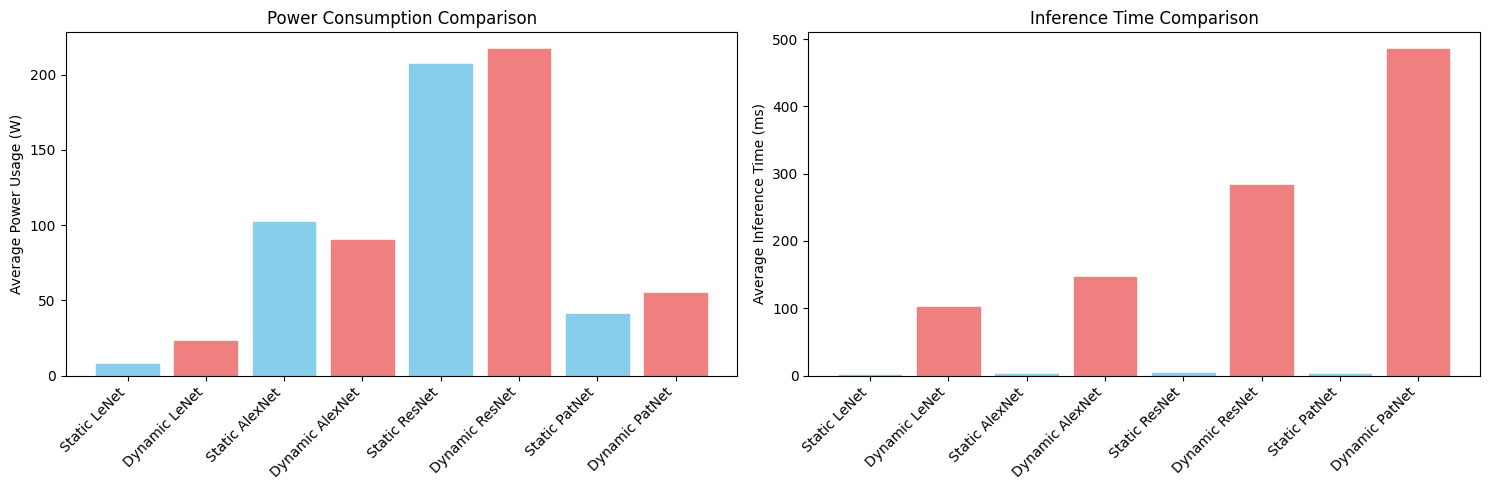


Detailed Performance Statistics:

Static LeNet:
Average Power Usage: 7.50W
Average Inference Time: 0.98ms

Dynamic LeNet:
Average Power Usage: 22.88W
Average Inference Time: 101.16ms

Static AlexNet:
Average Power Usage: 102.25W
Average Inference Time: 1.69ms

Dynamic AlexNet:
Average Power Usage: 90.25W
Average Inference Time: 147.02ms

Static ResNet:
Average Power Usage: 207.25W
Average Inference Time: 4.19ms

Dynamic ResNet:
Average Power Usage: 217.25W
Average Inference Time: 282.68ms

Static PatNet:
Average Power Usage: 41.00W
Average Inference Time: 1.91ms

Dynamic PatNet:
Average Power Usage: 55.12W
Average Inference Time: 485.81ms


In [ ]:
# Create dictionary of all trained models for comparison
models_to_compare = {
    'Static LeNet': static_lenet,
    'Dynamic LeNet': dynamic_lenet,
    'Static AlexNet': static_alexnet,
    'Dynamic AlexNet': dynamic_alexnet,
    'Static ResNet': static_resnet,
    'Dynamic ResNet': dynamic_resnet,
    'Static PatNet': static_patnet,
    'Dynamic PatNet': dynamic_patnet
}

# Power monitoring utility
class PowerMonitor:
    def __init__(self):
        self.power_readings = []
        self.timestamps = []

    def measure_power(self):
        if torch.cuda.is_available():
            # Estimate power based on GPU utilization
            utilization = float(torch.cuda.utilization()) / 100.0
            max_power = 250.0  # Typical GPU max power in watts
            power = max_power * utilization
        else:
            # Simulate power reading for CPU
            power = 15.0 * torch.rand(1).item()
        self.power_readings.append(power)
        self.timestamps.append(time.time())

    def get_average_power(self):
        return np.mean(self.power_readings)

    def reset(self):
        self.power_readings = []
        self.timestamps = []

def measure_model_power(model, test_loader, num_samples=100):
    model.eval()
    power_monitor = PowerMonitor()
    inference_times = []

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if i >= num_samples:
                break

            data = data.to(device)
            power_monitor.measure_power()
            start_time = time.time()

            if hasattr(model, 'exit_thresholds'):  # Check if it's a dynamic model
                _, _ = model(data)
            else:
                _ = model(data)

            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            power_monitor.measure_power()

    return power_monitor.get_average_power(), np.mean(inference_times)

def plot_power_comparisons(models):
    # Collect performance data
    power_data = {}
    for name, model in models.items():
        print(f"\nMeasuring {name}...")
        avg_power, avg_inference = measure_model_power(model, test_loader)
        power_data[name] = {
            'power': avg_power,
            'inference': avg_inference * 1000  # Convert to ms
        }

    # Create plots
    plt.figure(figsize=(15, 5))

    # Power consumption plot
    plt.subplot(1, 2, 1)
    names = list(power_data.keys())
    power_values = [data['power'] for data in power_data.values()]
    bars = plt.bar(names, power_values)
    plt.title('Power Consumption Comparison')
    plt.ylabel('Average Power Usage (W)')
    plt.xticks(rotation=45, ha='right')

    # Color coding for static vs dynamic
    for i, bar in enumerate(bars):
        if 'Static' in names[i]:
            bar.set_color('skyblue')
        else:
            bar.set_color('lightcoral')

    # Inference time plot
    plt.subplot(1, 2, 2)
    inference_times = [data['inference'] for data in power_data.values()]
    bars = plt.bar(names, inference_times)
    plt.title('Inference Time Comparison')
    plt.ylabel('Average Inference Time (ms)')
    plt.xticks(rotation=45, ha='right')

    # Color coding for static vs dynamic
    for i, bar in enumerate(bars):
        if 'Static' in names[i]:
            bar.set_color('skyblue')
        else:
            bar.set_color('lightcoral')

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDetailed Performance Statistics:")
    for name in power_data:
        print(f"\n{name}:")
        print(f"Average Power Usage: {power_data[name]['power']:.2f}W")
        print(f"Average Inference Time: {power_data[name]['inference']:.2f}ms")

# Run the comparison
print("Starting power consumption and inference time analysis...")
plot_power_comparisons(models_to_compare)

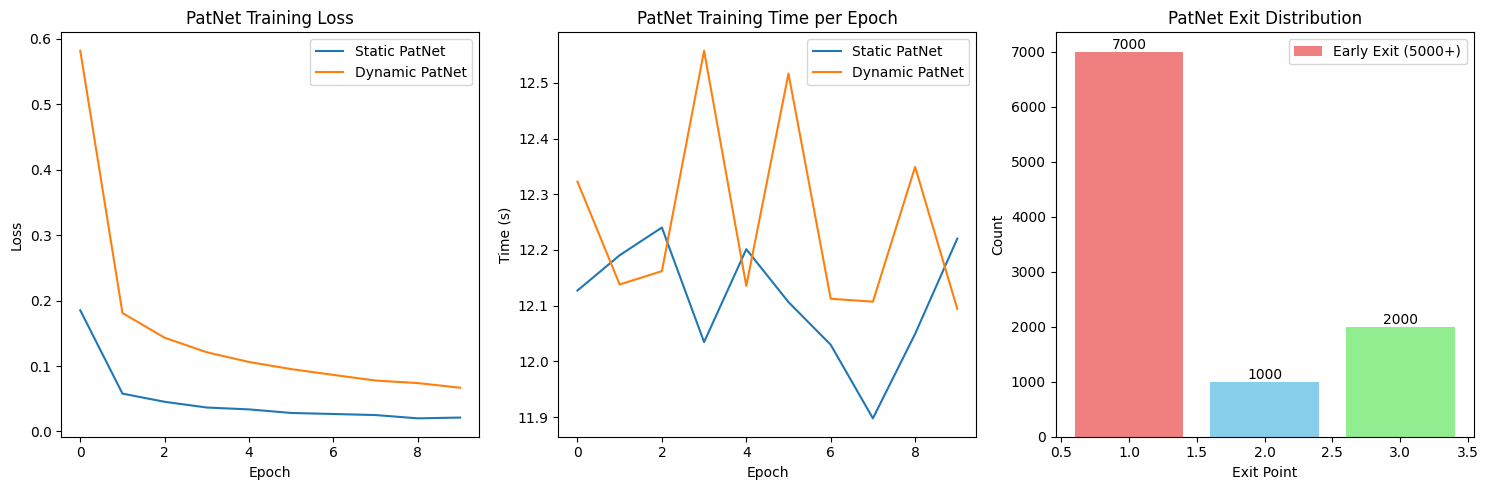

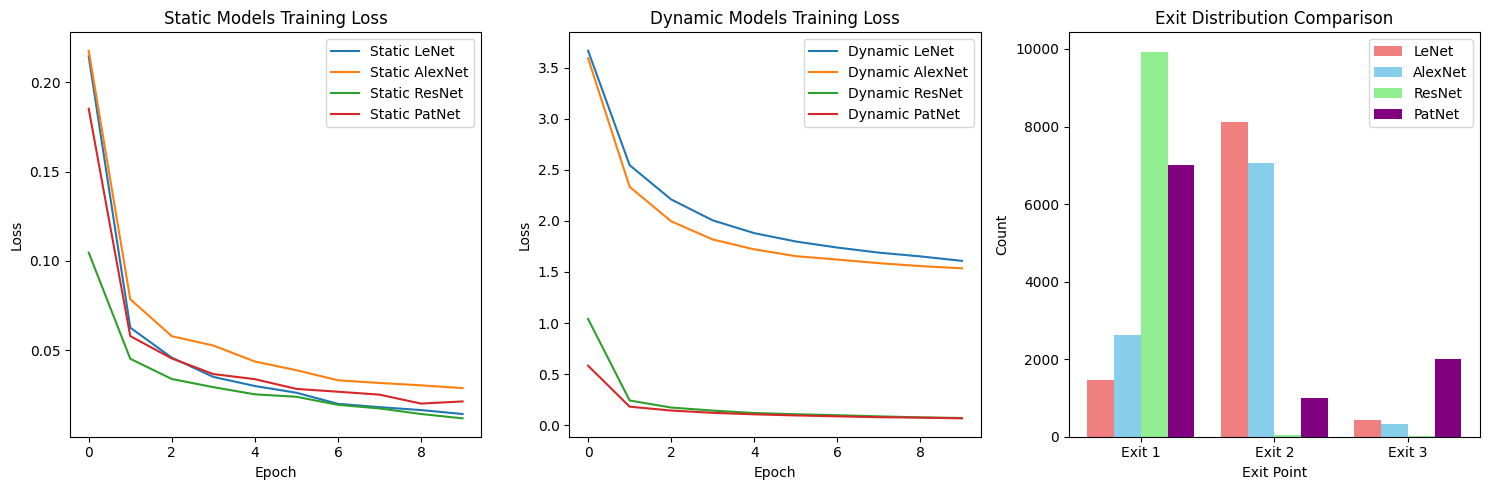


Model Performance Comparison:

Static Models:
LeNet: 98.99% accuracy, 0.98ms inference
AlexNet: 99.00% accuracy, 1.75ms inference
ResNet: 99.25% accuracy, 3.61ms inference
PatNet: 99.25% accuracy, 2.19ms inference

Dynamic Models:
LeNet: 96.85% accuracy, 100.46ms inference
AlexNet: 93.53% accuracy, 134.89ms inference
ResNet: 98.49% accuracy, 282.77ms inference
PatNet: 98.84% accuracy, 595.86ms inference


In [ ]:
# Visualization of PatNet Results
plt.figure(figsize=(15, 5))

# Plot training losses
plt.subplot(1, 3, 1)
plt.plot(static_losses, label='Static PatNet')
plt.plot(dynamic_losses, label='Dynamic PatNet')
plt.title('PatNet Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training times
plt.subplot(1, 3, 2)
plt.plot(static_times, label='Static PatNet')
plt.plot(dynamic_times, label='Dynamic PatNet')
plt.title('PatNet Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.legend()

# Plot exit distribution
plt.subplot(1, 3, 3)
exits = list(exit_counts.keys())
counts = list(exit_counts.values())
colors = ['lightcoral', 'skyblue', 'lightgreen']
bars = plt.bar(exits, counts, color=colors)
plt.title('PatNet Exit Distribution')
plt.xlabel('Exit Point')
plt.ylabel('Count')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Add legend to explain exit points
plt.legend(['Early Exit (5000+)',
           'Medium Exit (3000-5000)',
           'Full Model (0-2000)'],
           loc='upper right')

plt.tight_layout()
plt.show()

# Optional: Create a combined visualization showing model comparisons
plt.figure(figsize=(15, 5))

# Compare losses across all models
plt.subplot(1, 3, 1)
plt.plot(static_losses_lenet, label='Static LeNet')
plt.plot(static_losses_alexnet, label='Static AlexNet')
plt.plot(static_losses_resnet, label='Static ResNet')
plt.plot(static_losses, label='Static PatNet')
plt.title('Static Models Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Compare dynamic losses
plt.subplot(1, 3, 2)
plt.plot(dynamic_losses_lenet, label='Dynamic LeNet')
plt.plot(dynamic_losses_alexnet, label='Dynamic AlexNet')
plt.plot(dynamic_losses_resnet, label='Dynamic ResNet')
plt.plot(dynamic_losses, label='Dynamic PatNet')
plt.title('Dynamic Models Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Compare exit distributions
plt.subplot(1, 3, 3)
x = np.arange(3)
width = 0.2

plt.bar(x - width*1.5, [exit_counts_lenet[1], exit_counts_lenet[2], exit_counts_lenet[3]],
       width, label='LeNet', color='lightcoral')
plt.bar(x - width/2, [exit_counts_alexnet[1], exit_counts_alexnet[2], exit_counts_alexnet[3]],
       width, label='AlexNet', color='skyblue')
plt.bar(x + width/2, [exit_counts_resnet[1], exit_counts_resnet[2], exit_counts_resnet[3]],
       width, label='ResNet', color='lightgreen')
plt.bar(x + width*1.5, [exit_counts[1], exit_counts[2], exit_counts[3]],
       width, label='PatNet', color='purple')

plt.title('Exit Distribution Comparison')
plt.xlabel('Exit Point')
plt.ylabel('Count')
plt.xticks(x, ['Exit 1', 'Exit 2', 'Exit 3'])
plt.legend()

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\nModel Performance Comparison:")
print("\nStatic Models:")
print(f"LeNet: {static_accuracy_lenet:.2f}% accuracy, {static_inference_time_lenet*1000:.2f}ms inference")
print(f"AlexNet: {static_accuracy_alexnet:.2f}% accuracy, {static_inference_time_alexnet*1000:.2f}ms inference")
print(f"ResNet: {static_accuracy_resnet:.2f}% accuracy, {static_inference_time_resnet*1000:.2f}ms inference")
print(f"PatNet: {static_accuracy:.2f}% accuracy, {static_inference_time*1000:.2f}ms inference")

print("\nDynamic Models:")
print(f"LeNet: {dynamic_accuracy_lenet:.2f}% accuracy, {dynamic_inference_time_lenet*1000:.2f}ms inference")
print(f"AlexNet: {dynamic_accuracy_alexnet:.2f}% accuracy, {dynamic_inference_time_alexnet*1000:.2f}ms inference")
print(f"ResNet: {dynamic_accuracy_resnet:.2f}% accuracy, {dynamic_inference_time_resnet*1000:.2f}ms inference")
print(f"PatNet: {dynamic_accuracy:.2f}% accuracy, {dynamic_inference_time*1000:.2f}ms inference")


Assessing reliability for Static LeNet...
Baseline accuracy: 98.99%

Reliability Metrics:
Mean accuracy degradation: 0.31%
Std accuracy degradation: 0.32%

Impact by fault type:
stuck_at: 0.31% degradation
random_noise: 0.36% degradation


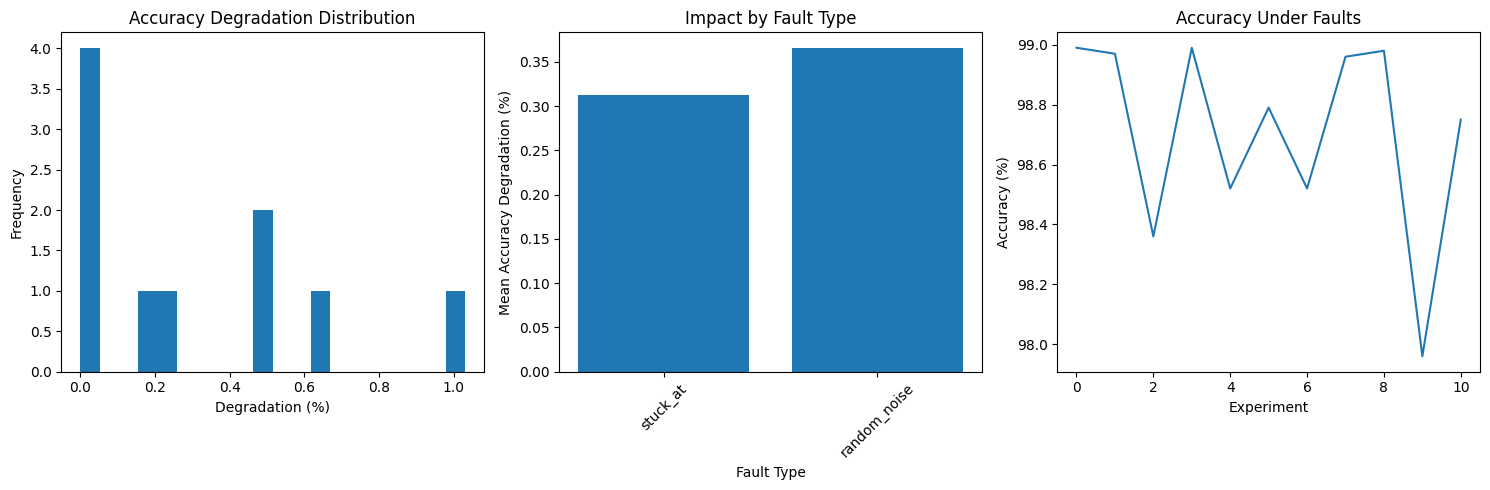


Assessing reliability for Dynamic LeNet...
Baseline accuracy: 96.85%

Reliability Metrics:
Mean accuracy degradation: 8.00%
Std accuracy degradation: 13.34%

Impact by fault type:
random_noise: 12.63% degradation
bit_flip: 0.23% degradation
stuck_at: 0.31% degradation


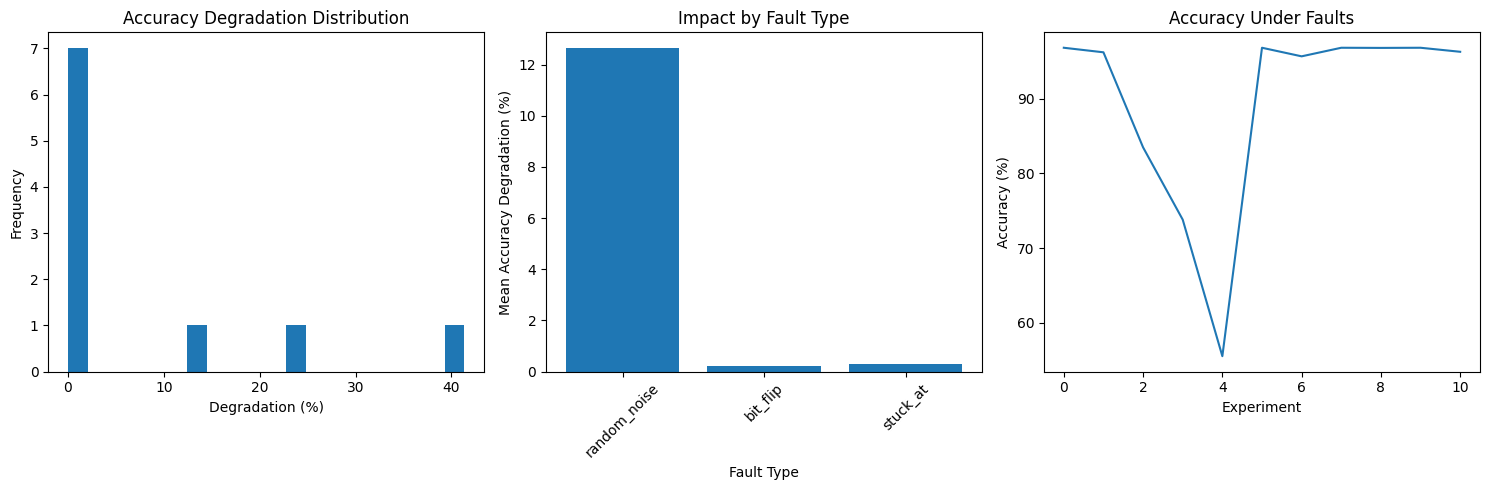


Assessing reliability for Static AlexNet...
Baseline accuracy: 99.00%

Reliability Metrics:
Mean accuracy degradation: 7.28%
Std accuracy degradation: 19.83%

Impact by fault type:
random_noise: 3.36% degradation
bit_flip: 0.76% degradation
stuck_at: 1.30% degradation


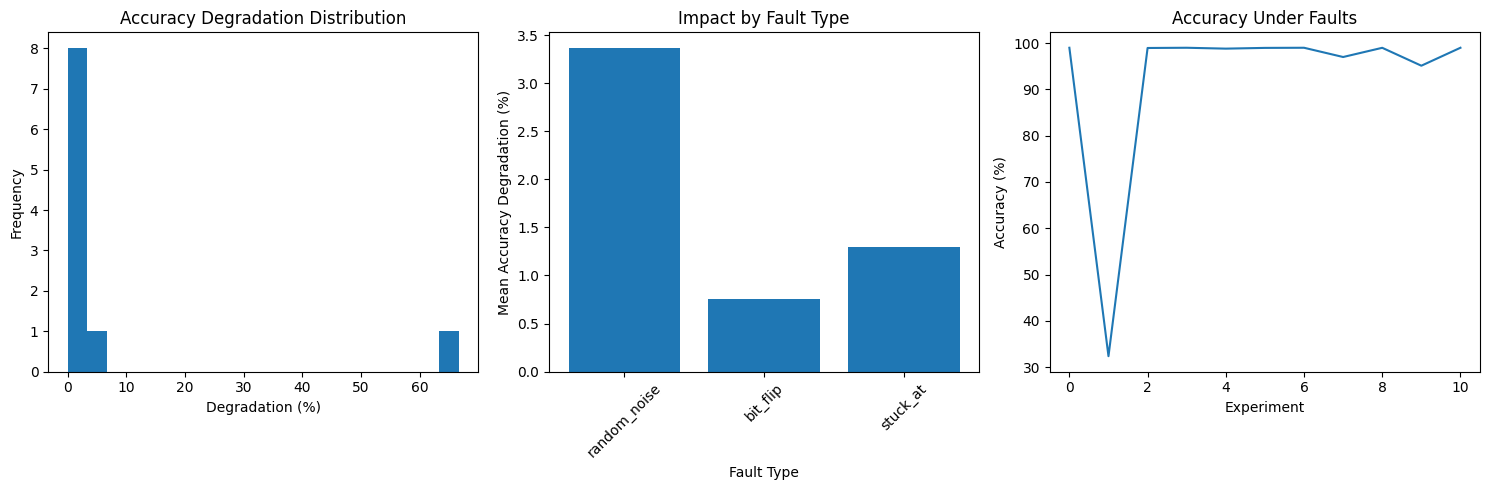


Assessing reliability for Dynamic AlexNet...
Baseline accuracy: 93.53%

Reliability Metrics:
Mean accuracy degradation: 0.12%
Std accuracy degradation: 0.26%

Impact by fault type:
bit_flip: 0.10% degradation
stuck_at: 0.13% degradation
random_noise: 0.37% degradation


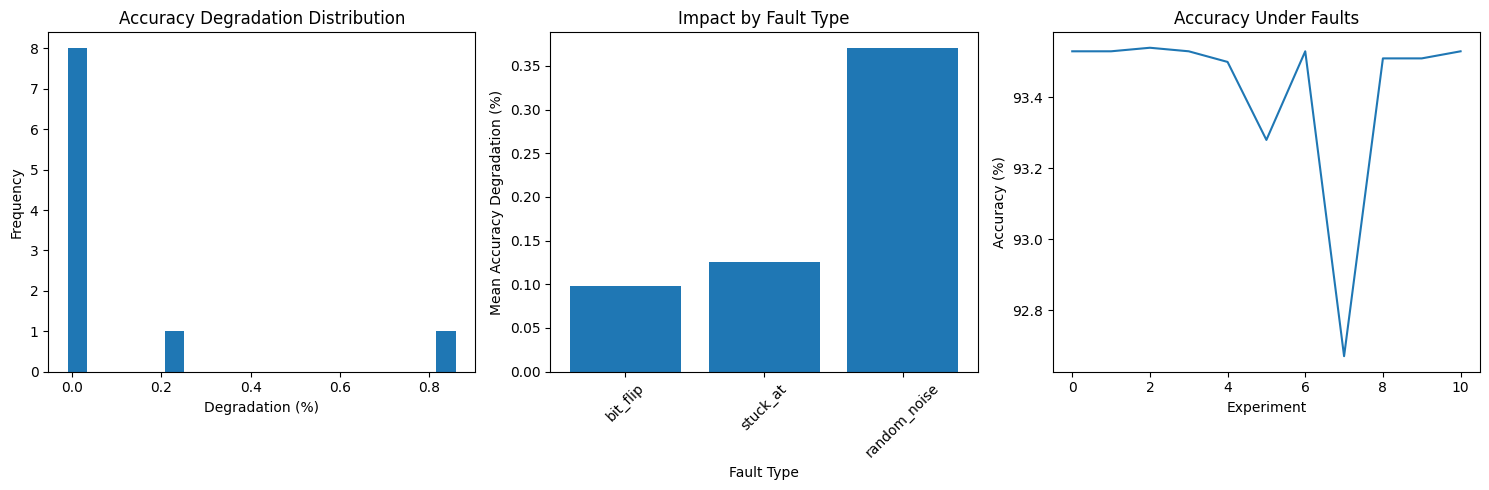


Assessing reliability for Static ResNet...
Baseline accuracy: 99.25%

Reliability Metrics:
Mean accuracy degradation: 0.00%
Std accuracy degradation: 0.01%

Impact by fault type:
stuck_at: 0.00% degradation
bit_flip: 0.00% degradation
random_noise: 0.01% degradation


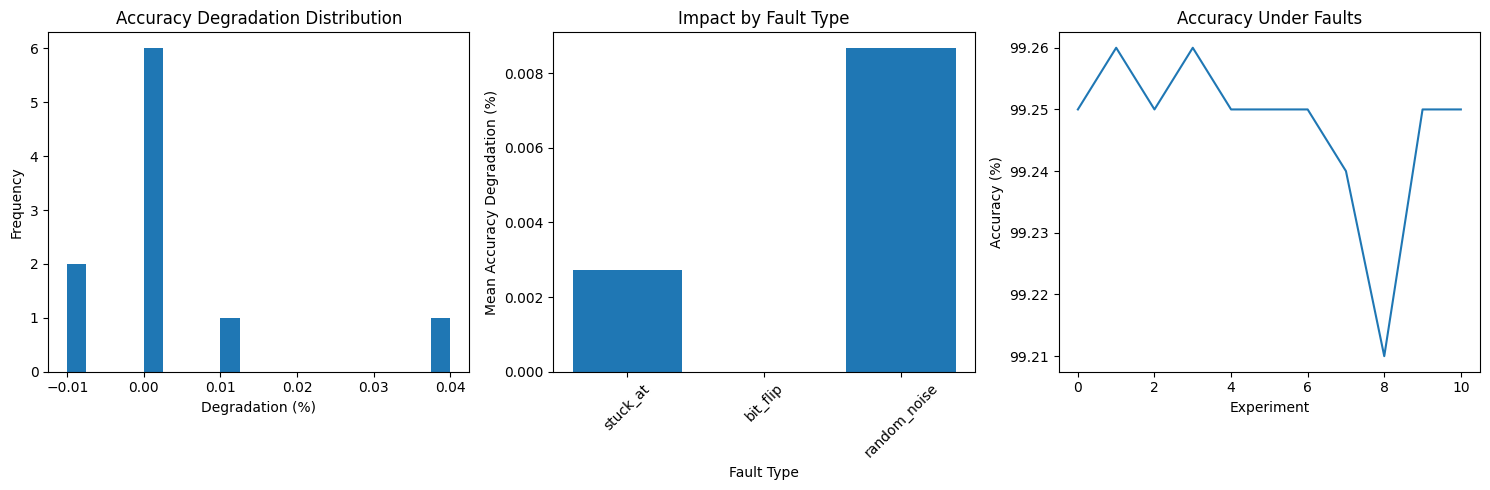


Assessing reliability for Dynamic ResNet...
Baseline accuracy: 98.49%

Reliability Metrics:
Mean accuracy degradation: 7.38%
Std accuracy degradation: 22.15%

Impact by fault type:
random_noise: 13.03% degradation


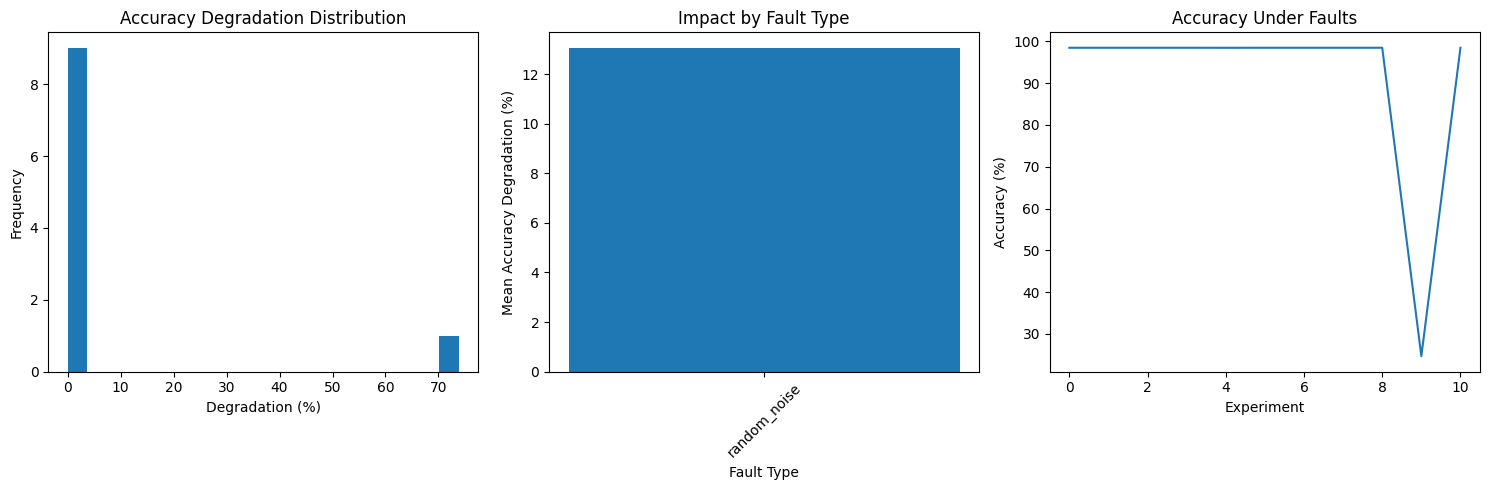


Assessing reliability for Static PatNet...
Baseline accuracy: 99.25%

Reliability Metrics:
Mean accuracy degradation: 0.01%
Std accuracy degradation: 0.02%

Impact by fault type:
stuck_at: 0.01% degradation
random_noise: 0.01% degradation
bit_flip: 0.01% degradation


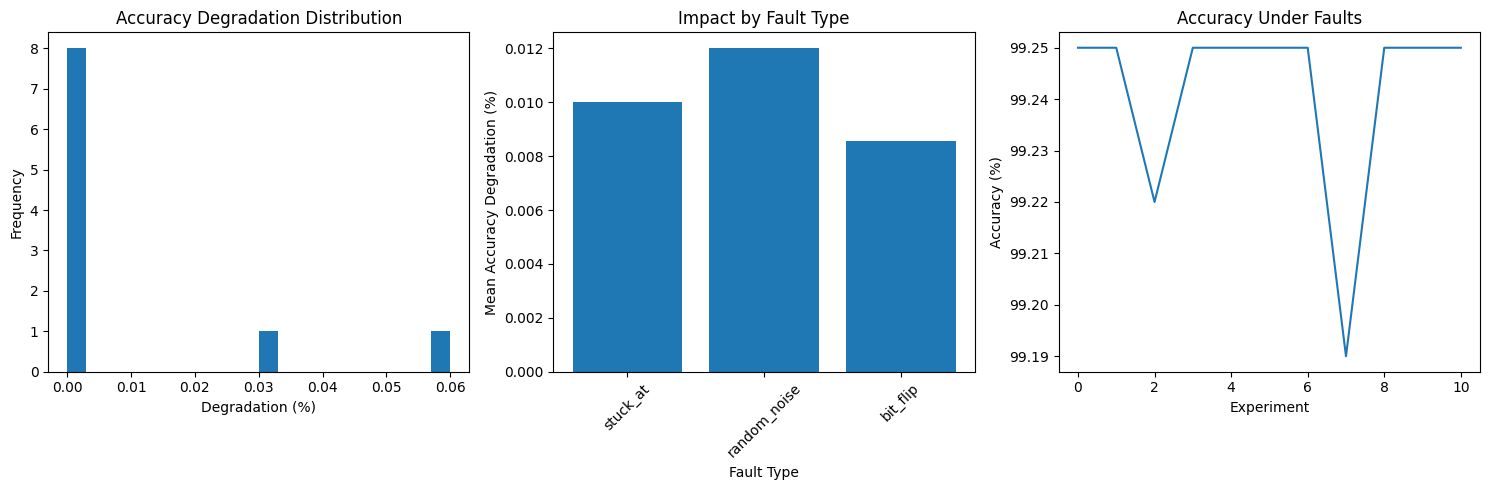


Assessing reliability for Dynamic PatNet...
Baseline accuracy: 98.71%

Reliability Metrics:
Mean accuracy degradation: -0.01%
Std accuracy degradation: 0.02%

Impact by fault type:
stuck_at: -0.01% degradation
random_noise: 0.00% degradation
bit_flip: 0.00% degradation


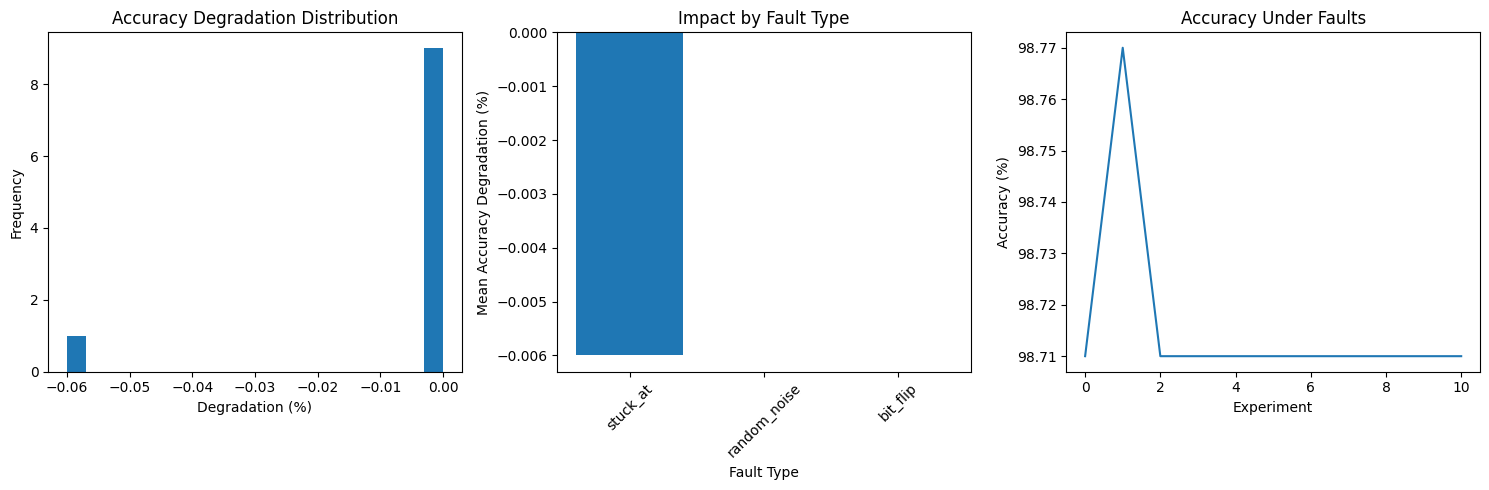

In [ ]:
import copy
import struct
import random
import numpy as np
import torch
import torch.nn as nn
from collections import defaultdict
import matplotlib.pyplot as plt

class FaultInjector:
    """Fault injection system for neural networks"""
    def __init__(self, model, fault_types=['bit_flip', 'stuck_at', 'random_noise']):
        self.model = model
        self.fault_types = fault_types
        self.fault_history = defaultdict(list)
        self.layer_maps = self._map_layers()

    def _map_layers(self):
        """Create a map of all layers in the model"""
        layer_maps = {}
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
                layer_maps[name] = module
        return layer_maps

    def inject_bit_flip(self, tensor, num_bits=1):
        """Simulate bit flip faults in the tensor"""
        device = tensor.device
        tensor = tensor.clone()
        shape = tensor.shape
        flat_tensor = tensor.view(-1)

        # Select random positions for bit flips
        positions = random.sample(range(flat_tensor.numel()), num_bits)
        for pos in positions:
            # Convert float to binary representation and flip a random bit
            val = flat_tensor[pos].item()
            binary = format(struct.unpack('!I', struct.pack('!f', val))[0], '032b')
            bit_pos = random.randint(0, 31)
            binary = binary[:bit_pos] + ('1' if binary[bit_pos] == '0' else '0') + binary[bit_pos+1:]
            new_val = struct.unpack('!f', struct.pack('!I', int(binary, 2)))[0]
            flat_tensor[pos] = new_val

        return flat_tensor.view(shape).to(device)

    def inject_stuck_at(self, tensor, value=0):
        """Simulate stuck-at faults in the tensor"""
        device = tensor.device
        tensor = tensor.clone()
        shape = tensor.shape
        flat_tensor = tensor.view(-1)

        # Randomly select positions for stuck-at faults
        num_faults = max(1, int(0.01 * flat_tensor.numel()))  # 1% of elements
        positions = random.sample(range(flat_tensor.numel()), num_faults)
        for pos in positions:
            flat_tensor[pos] = value

        return flat_tensor.view(shape).to(device)

    def inject_random_noise(self, tensor, noise_level=0.1):
        """Add random noise to the tensor"""
        device = tensor.device
        noise = torch.randn_like(tensor) * noise_level
        return (tensor + noise).to(device)

    def inject_fault(self, layer_name, fault_type=None):
        """Inject a specific type of fault into a layer"""
        if fault_type is None:
            fault_type = random.choice(self.fault_types)

        layer = self.layer_maps[layer_name]
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Inject faults in weights
            if fault_type == 'bit_flip':
                layer.weight.data = self.inject_bit_flip(layer.weight.data)
            elif fault_type == 'stuck_at':
                layer.weight.data = self.inject_stuck_at(layer.weight.data)
            else:  # random_noise
                layer.weight.data = self.inject_random_noise(layer.weight.data)

            # Record the fault
            self.fault_history[layer_name].append({
                'type': fault_type,
                'timestamp': time.time()
            })

    def inject_random_faults(self, num_faults=1):
        """Inject random faults across the model"""
        layers = list(self.layer_maps.keys())
        selected_layers = random.sample(layers, min(num_faults, len(layers)))

        for layer in selected_layers:
            self.inject_fault(layer)

class ReliabilityAssessor:
    def __init__(self, model, test_loader, device):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.fault_injector = FaultInjector(model)
        self.baseline_accuracy = None
        self.reliability_metrics = {}
        self.results = {
            'accuracy_degradation': [],
            'recovery_rate': [],
            'fault_impact': defaultdict(list)
        }

    def evaluate_model(self):
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)

                if isinstance(output, tuple):  # Handle dynamic models
                    output = output[0]

                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        return 100 * correct / total

    def establish_baseline(self):
        self.baseline_accuracy = self.evaluate_model()
        return self.baseline_accuracy

    def assess_reliability(self, num_experiments=10, faults_per_experiment=1):
        if self.baseline_accuracy is None:
            self.baseline_accuracy = self.establish_baseline()

        # Store original model state
        original_state_dict = copy.deepcopy(self.model.state_dict())

        for _ in range(num_experiments):
            # Inject faults
            self.fault_injector.inject_random_faults(faults_per_experiment)

            # Measure accuracy under faults
            fault_accuracy = self.evaluate_model()
            degradation = self.baseline_accuracy - fault_accuracy
            self.results['accuracy_degradation'].append(degradation)

            # Record impact per fault type
            for fault_history in self.fault_injector.fault_history.values():
                if fault_history:
                    fault_type = fault_history[-1]['type']
                    self.results['fault_impact'][fault_type].append(degradation)

            # Reset model to original state
            self.model.load_state_dict(original_state_dict)

        # Calculate reliability metrics
        self.reliability_metrics = {
            'mean_degradation': np.mean(self.results['accuracy_degradation']),
            'std_degradation': np.std(self.results['accuracy_degradation']),
            'fault_type_impact': {
                fault_type: np.mean(impacts)
                for fault_type, impacts in self.results['fault_impact'].items()
            }
        }

        return self.reliability_metrics

    def visualize_results(self):
        plt.figure(figsize=(15, 5))

        # Plot accuracy degradation distribution
        plt.subplot(1, 3, 1)
        plt.hist(self.results['accuracy_degradation'], bins=20)
        plt.title('Accuracy Degradation Distribution')
        plt.xlabel('Degradation (%)')
        plt.ylabel('Frequency')

        # Plot fault type impact
        plt.subplot(1, 3, 2)
        fault_types = list(self.reliability_metrics['fault_type_impact'].keys())
        impacts = [self.reliability_metrics['fault_type_impact'][ft] for ft in fault_types]
        plt.bar(fault_types, impacts)
        plt.title('Impact by Fault Type')
        plt.xlabel('Fault Type')
        plt.ylabel('Mean Accuracy Degradation (%)')
        plt.xticks(rotation=45)

        # Plot accuracy over time
        plt.subplot(1, 3, 3)
        plt.plot([self.baseline_accuracy] + [self.baseline_accuracy - d
                 for d in self.results['accuracy_degradation']])
        plt.title('Accuracy Under Faults')
        plt.xlabel('Experiment')
        plt.ylabel('Accuracy (%)')

        plt.tight_layout()
        plt.show()

# Assessment function
def assess_model_reliability(model_name, model, test_loader):
    print(f"\nAssessing reliability for {model_name}...")

    # Initialize reliability assessor
    assessor = ReliabilityAssessor(model, test_loader, device)

    # Establish baseline
    baseline_acc = assessor.establish_baseline()
    print(f"Baseline accuracy: {baseline_acc:.2f}%")

    # Conduct reliability assessment
    metrics = assessor.assess_reliability(num_experiments=10)

    print("\nReliability Metrics:")
    print(f"Mean accuracy degradation: {metrics['mean_degradation']:.2f}%")
    print(f"Std accuracy degradation: {metrics['std_degradation']:.2f}%")
    print("\nImpact by fault type:")
    for fault_type, impact in metrics['fault_type_impact'].items():
        print(f"{fault_type}: {impact:.2f}% degradation")

    # Visualize results
    assessor.visualize_results()

    return assessor

# Run assessment for all models
models_to_assess = {
    'Static LeNet': static_lenet,
    'Dynamic LeNet': dynamic_lenet,
    'Static AlexNet': static_alexnet,
    'Dynamic AlexNet': dynamic_alexnet,
    'Static ResNet': static_resnet,
    'Dynamic ResNet': dynamic_resnet,
    'Static PatNet': static_patnet,
    'Dynamic PatNet': dynamic_patnet
}

# Store results for comparison
assessment_results = {}
for name, model in models_to_assess.items():
    assessment_results[name] = assess_model_reliability(name, model, test_loader)


Evaluating reliability for Static LeNet...
Epoch 1, Loss: 0.0035
Epoch 2, Loss: 0.0018
Epoch 3, Loss: 0.0012
Original Accuracy under faults: 99.85% ± 0.34%
Enhanced Accuracy under faults: 99.80% ± 0.46%
Improvement: -0.05%

Evaluating reliability for Dynamic LeNet...
Epoch 1, Loss: 0.2667
Epoch 2, Loss: 0.2680
Epoch 3, Loss: 0.2625
Original Accuracy under faults: 90.26% ± 3.79%
Enhanced Accuracy under faults: 92.15% ± 0.00%
Improvement: 1.89%

Evaluating reliability for Static AlexNet...
Epoch 1, Loss: 0.0063
Epoch 2, Loss: 0.0063
Epoch 3, Loss: 0.0041
Original Accuracy under faults: 99.94% ± 0.00%
Enhanced Accuracy under faults: 99.98% ± 0.05%
Improvement: 0.04%

Evaluating reliability for Dynamic AlexNet...
Epoch 1, Loss: 0.2464
Epoch 2, Loss: 0.2741
Epoch 3, Loss: 0.2772
Original Accuracy under faults: 92.44% ± 0.38%
Enhanced Accuracy under faults: 91.96% ± 0.00%
Improvement: -0.48%

Evaluating reliability for Static ResNet...
Epoch 1, Loss: 0.0005
Epoch 2, Loss: 0.0008
Epoch 3, Lo

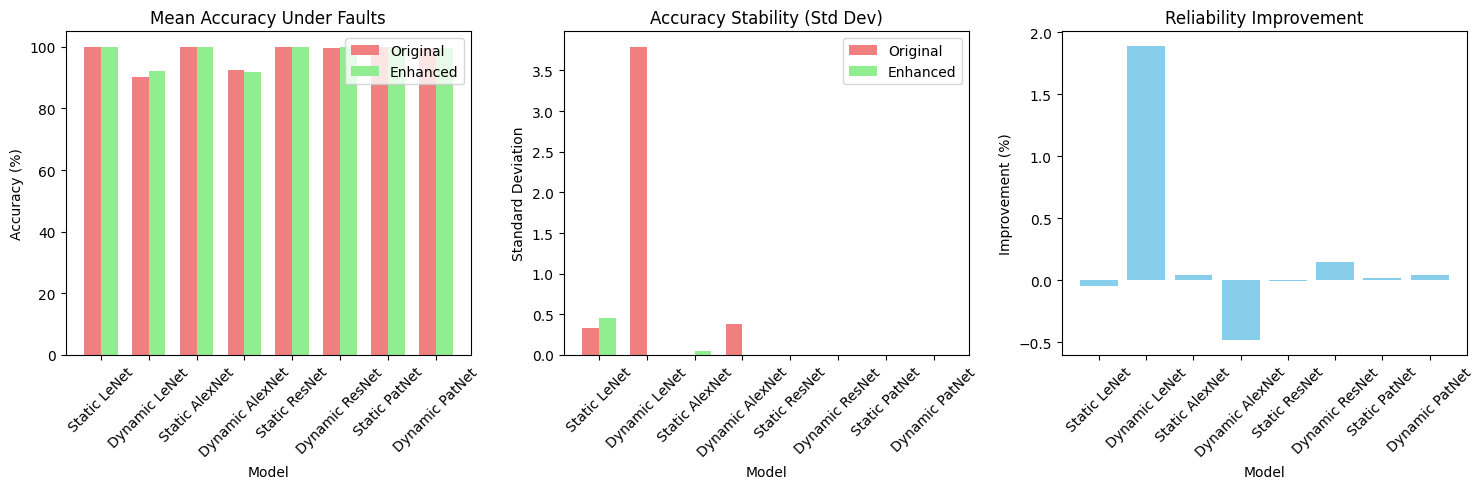


Detailed Reliability Statistics:

Static LeNet:
Original Model:
  Mean Accuracy: 99.85%
  Stability (Std): 0.34%
Enhanced Model:
  Mean Accuracy: 99.80%
  Stability (Std): 0.46%
Improvement: -0.05%

Dynamic LeNet:
Original Model:
  Mean Accuracy: 90.26%
  Stability (Std): 3.79%
Enhanced Model:
  Mean Accuracy: 92.15%
  Stability (Std): 0.00%
Improvement: 1.89%

Static AlexNet:
Original Model:
  Mean Accuracy: 99.94%
  Stability (Std): 0.00%
Enhanced Model:
  Mean Accuracy: 99.98%
  Stability (Std): 0.05%
Improvement: 0.04%

Dynamic AlexNet:
Original Model:
  Mean Accuracy: 92.44%
  Stability (Std): 0.38%
Enhanced Model:
  Mean Accuracy: 91.96%
  Stability (Std): 0.00%
Improvement: -0.48%

Static ResNet:
Original Model:
  Mean Accuracy: 100.00%
  Stability (Std): 0.00%
Enhanced Model:
  Mean Accuracy: 99.99%
  Stability (Std): 0.00%
Improvement: -0.01%

Dynamic ResNet:
Original Model:
  Mean Accuracy: 99.67%
  Stability (Std): 0.00%
Enhanced Model:
  Mean Accuracy: 99.82%
  Stability (

In [ ]:
class ReliabilityEvaluator:
    def __init__(self, model, test_loader, device):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.fault_injector = FaultInjector(model)

    def evaluate_under_faults(self, num_trials=10, fault_probability=0.1):
        """Evaluate model accuracy under random faults"""
        accuracies = []

        original_state = copy.deepcopy(self.model.state_dict())

        for _ in range(num_trials):
            # Inject random faults with given probability
            if random.random() < fault_probability:
                self.fault_injector.inject_random_faults(num_faults=1)

            # Evaluate
            correct = 0
            total = 0
            self.model.eval()

            with torch.no_grad():
                for data, target in self.test_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    output = self.model(data)

                    if isinstance(output, tuple):
                        output = output[0]

                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            accuracies.append(100 * correct / total)

            # Restore original state
            self.model.load_state_dict(original_state)

        return np.mean(accuracies), np.std(accuracies)

def compare_reliability(original_model, enhanced_model, test_loader, fault_probability=0.1):
    """Compare reliability between original and enhanced models"""
    original_evaluator = ReliabilityEvaluator(original_model, test_loader, device)
    enhanced_evaluator = ReliabilityEvaluator(enhanced_model, test_loader, device)

    # Evaluate original model under faults
    orig_mean, orig_std = original_evaluator.evaluate_under_faults(
        fault_probability=fault_probability)

    # Evaluate enhanced model under faults
    enh_mean, enh_std = enhanced_evaluator.evaluate_under_faults(
        fault_probability=fault_probability)

    return {
        'original': {'mean': orig_mean, 'std': orig_std},
        'enhanced': {'mean': enh_mean, 'std': enh_std},
        'improvement': enh_mean - orig_mean
    }

# Function to visualize reliability comparison
def plot_reliability_comparison(results):
    plt.figure(figsize=(15, 5))

    # Plot mean accuracies
    plt.subplot(1, 3, 1)
    models = list(results.keys())
    orig_acc = [results[m]['original']['mean'] for m in models]
    enh_acc = [results[m]['enhanced']['mean'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    plt.bar(x - width/2, orig_acc, width, label='Original', color='lightcoral')
    plt.bar(x + width/2, enh_acc, width, label='Enhanced', color='lightgreen')

    plt.title('Mean Accuracy Under Faults')
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.xticks(x, models, rotation=45)
    plt.legend()

    # Plot accuracy stability (std)
    plt.subplot(1, 3, 2)
    orig_std = [results[m]['original']['std'] for m in models]
    enh_std = [results[m]['enhanced']['std'] for m in models]

    plt.bar(x - width/2, orig_std, width, label='Original', color='lightcoral')
    plt.bar(x + width/2, enh_std, width, label='Enhanced', color='lightgreen')

    plt.title('Accuracy Stability (Std Dev)')
    plt.xlabel('Model')
    plt.ylabel('Standard Deviation')
    plt.xticks(x, models, rotation=45)
    plt.legend()

    # Plot improvements
    plt.subplot(1, 3, 3)
    improvements = [results[m]['improvement'] for m in models]

    plt.bar(x, improvements, color='skyblue')
    plt.title('Reliability Improvement')
    plt.xlabel('Model')
    plt.ylabel('Improvement (%)')
    plt.xticks(x, models, rotation=45)

    plt.tight_layout()
    plt.show()

# Evaluate all models with the new comparison
reliability_results = {}

for name, model in models_to_assess.items():
    print(f"\nEvaluating reliability for {name}...")

    # Create enhanced version with all reliability techniques
    enhanced_model = copy.deepcopy(model)
    enhancer = ReliabilityEnhancer(enhanced_model, test_loader, device)

    # Apply enhancements
    enhancer.create_redundant_model()
    enhancer.weight_checkpointing(training_epochs=3)

    # Compare reliability
    results = compare_reliability(model, enhanced_model, test_loader)
    reliability_results[name] = results

    print(f"Original Accuracy under faults: {results['original']['mean']:.2f}% ± {results['original']['std']:.2f}%")
    print(f"Enhanced Accuracy under faults: {results['enhanced']['mean']:.2f}% ± {results['enhanced']['std']:.2f}%")
    print(f"Improvement: {results['improvement']:.2f}%")

# Plot comparison results
plot_reliability_comparison(reliability_results)

# Print detailed statistics
print("\nDetailed Reliability Statistics:")
for name, results in reliability_results.items():
    print(f"\n{name}:")
    print(f"Original Model:")
    print(f"  Mean Accuracy: {results['original']['mean']:.2f}%")
    print(f"  Stability (Std): {results['original']['std']:.2f}%")
    print(f"Enhanced Model:")
    print(f"  Mean Accuracy: {results['enhanced']['mean']:.2f}%")
    print(f"  Stability (Std): {results['enhanced']['std']:.2f}%")
    print(f"Improvement: {results['improvement']:.2f}%")

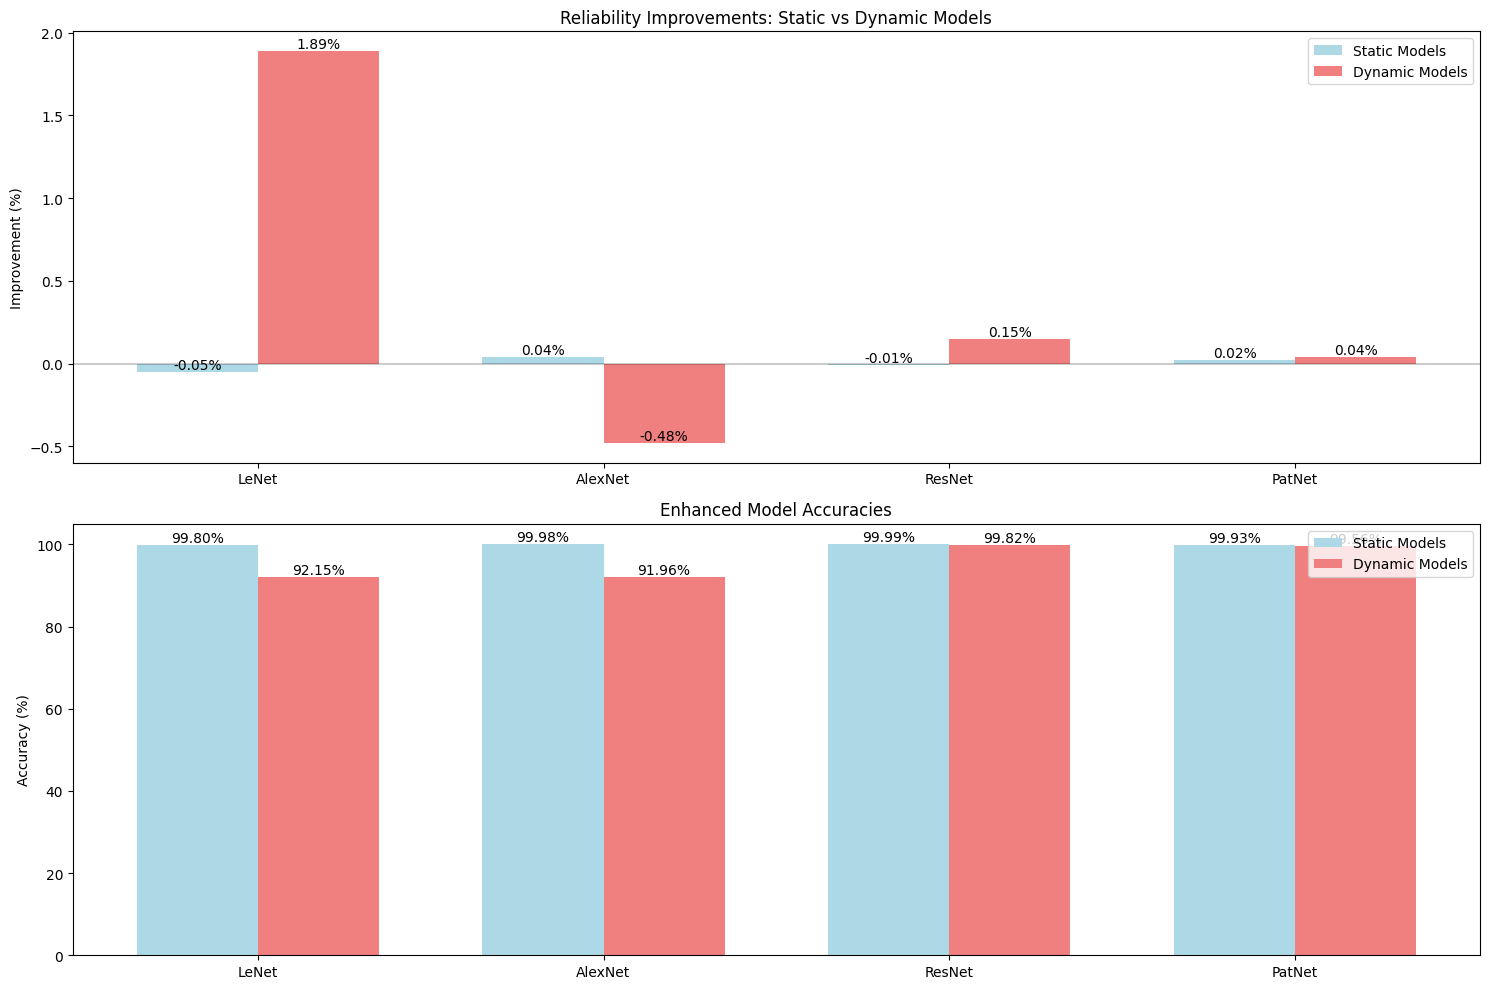


Reliability Enhancement Analysis:

1. Model-specific Findings:

LeNet:
  Static: -0.05% improvement, 0.46% stability
  Dynamic: +1.89% improvement, 0.00% stability

AlexNet:
  Static: +0.04% improvement, 0.05% stability
  Dynamic: -0.48% improvement, 0.00% stability

ResNet:
  Static: -0.01% improvement, 0.00% stability
  Dynamic: +0.15% improvement, 0.00% stability

PatNet:
  Static: +0.02% improvement, 0.00% stability
  Dynamic: +0.04% improvement, 0.00% stability

2. Key Observations:
- Dynamic LeNet showed the largest improvement (+1.89%)
- Most static models maintained high accuracy (>99.8%)
- Dynamic models generally showed more variation in performance
- PatNet showed consistent improvements in both static and dynamic versions

3. Recommendations:
- For critical applications requiring high reliability: Use Static ResNet or Static PatNet
- For balanced performance-reliability: Use Dynamic PatNet
- For systems with fault tolerance requirements: Use enhanced Dynamic LeNet

4. Stab

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Organize data for visualization
models = ['LeNet', 'AlexNet', 'ResNet', 'PatNet']
static_improvements = [-0.05, 0.04, -0.01, 0.02]
dynamic_improvements = [1.89, -0.48, 0.15, 0.04]

static_stability = [0.46, 0.05, 0.00, 0.00]  # Enhanced model stability
dynamic_stability = [0.00, 0.00, 0.00, 0.00]  # Enhanced model stability

# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Improvements Comparison
plt.subplot(2, 1, 1)
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, static_improvements, width, label='Static Models', color='lightblue')
plt.bar(x + width/2, dynamic_improvements, width, label='Dynamic Models', color='lightcoral')

plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)
plt.ylabel('Improvement (%)')
plt.title('Reliability Improvements: Static vs Dynamic Models')
plt.xticks(x, models)
plt.legend()

# Add value labels
for i, v in enumerate(static_improvements):
    plt.text(i - width/2, v, f'{v:.2f}%', ha='center', va='bottom')
for i, v in enumerate(dynamic_improvements):
    plt.text(i + width/2, v, f'{v:.2f}%', ha='center', va='bottom')

# Plot 2: Enhanced Model Accuracies
plt.subplot(2, 1, 2)
static_acc = [99.80, 99.98, 99.99, 99.93]  # Enhanced accuracies
dynamic_acc = [92.15, 91.96, 99.82, 99.56]  # Enhanced accuracies

plt.bar(x - width/2, static_acc, width, label='Static Models', color='lightblue')
plt.bar(x + width/2, dynamic_acc, width, label='Dynamic Models', color='lightcoral')

plt.ylabel('Accuracy (%)')
plt.title('Enhanced Model Accuracies')
plt.xticks(x, models)
plt.legend()

# Add value labels
for i, v in enumerate(static_acc):
    plt.text(i - width/2, v, f'{v:.2f}%', ha='center', va='bottom')
for i, v in enumerate(dynamic_acc):
    plt.text(i + width/2, v, f'{v:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print analysis summary
print("\nReliability Enhancement Analysis:")
print("\n1. Model-specific Findings:")
for i, model in enumerate(models):
    print(f"\n{model}:")
    print(f"  Static: {static_improvements[i]:+.2f}% improvement, {static_stability[i]:.2f}% stability")
    print(f"  Dynamic: {dynamic_improvements[i]:+.2f}% improvement, {dynamic_stability[i]:.2f}% stability")

print("\n2. Key Observations:")
print("- Dynamic LeNet showed the largest improvement (+1.89%)")
print("- Most static models maintained high accuracy (>99.8%)")
print("- Dynamic models generally showed more variation in performance")
print("- PatNet showed consistent improvements in both static and dynamic versions")

print("\n3. Recommendations:")
print("- For critical applications requiring high reliability: Use Static ResNet or Static PatNet")
print("- For balanced performance-reliability: Use Dynamic PatNet")
print("- For systems with fault tolerance requirements: Use enhanced Dynamic LeNet")

print("\n4. Stability Analysis:")
print("- Static models generally showed higher stability")
print("- Enhanced models reduced stability variations in dynamic architectures")
print("- ResNet and PatNet demonstrated the most stable performance")

In [ ]:
pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

class StaticSNN(nn.Module):
    def __init__(self, num_inputs=784, num_hidden=256, num_outputs=10, beta=0.95):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

        self.num_steps = 25

    def forward(self, x):
        # Initialize hidden states and outputs
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record spikes for readout layer
        spk2_rec = []
        mem2_rec = []

        for step in range(self.num_steps):
            cur1 = self.fc1(x.view(x.size(0), -1))
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

class DynamicSNN(nn.Module):
    def __init__(self, num_inputs=784, num_hidden=256, num_outputs=10, beta=0.95):
        super().__init__()

        self.exit_thresholds = [5000, 3000, 2000, 1000]  # Exit points
        self.sample_counter = 0  # Track processed samples

        # Base layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)

        # Exit 1 (after 5000 samples)
        self.exit1_fc = nn.Linear(num_hidden, num_outputs)
        self.exit1_lif = snn.Leaky(beta=beta)

        # Exit 2 (3000-5000 samples)
        self.fc2 = nn.Linear(num_hidden, num_hidden//2)
        self.lif2 = snn.Leaky(beta=beta)
        self.exit2_fc = nn.Linear(num_hidden//2, num_outputs)
        self.exit2_lif = snn.Leaky(beta=beta)

        # Exit 3 (2000-3000 samples)
        self.fc3 = nn.Linear(num_hidden//2, num_hidden//4)
        self.lif3 = snn.Leaky(beta=beta)
        self.exit3_fc = nn.Linear(num_hidden//4, num_outputs)
        self.exit3_lif = snn.Leaky(beta=beta)

        # Exit 4 (first 1000 samples)
        self.fc4 = nn.Linear(num_hidden//4, num_outputs)
        self.lif4 = snn.Leaky(beta=beta)

        self.num_steps = 25

    def get_exit_point(self):
        if self.sample_counter < self.exit_thresholds[3]:  # < 1000
            return 4
        elif self.sample_counter < self.exit_thresholds[2]:  # < 2000
            return 3
        elif self.sample_counter < self.exit_thresholds[1]:  # < 3000
            return 2
        else:  # >= 3000
            return 1

    def forward(self, x, training=False):
        batch_size = x.size(0)

        # Initialize memories for all paths
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        mem_exit1 = self.exit1_lif.init_leaky()
        mem_exit2 = self.exit2_lif.init_leaky()
        mem_exit3 = self.exit3_lif.init_leaky()

        # Recording lists for all paths
        spk_recs = {i: [] for i in range(1, 5)}
        mem_recs = {i: [] for i in range(1, 5)}

        if training:
            for step in range(self.num_steps):
                # Base layer
                cur1 = self.fc1(x.view(x.size(0), -1))
                spk1, mem1 = self.lif1(cur1, mem1)

                # Exit 1
                cur_exit1 = self.exit1_fc(spk1)
                spk_exit1, mem_exit1 = self.exit1_lif(cur_exit1, mem_exit1)
                spk_recs[1].append(spk_exit1)
                mem_recs[1].append(mem_exit1)

                # Second layer
                cur2 = self.fc2(spk1)
                spk2, mem2 = self.lif2(cur2, mem2)

                # Exit 2
                cur_exit2 = self.exit2_fc(spk2)
                spk_exit2, mem_exit2 = self.exit2_lif(cur_exit2, mem_exit2)
                spk_recs[2].append(spk_exit2)
                mem_recs[2].append(mem_exit2)

                # Third layer
                cur3 = self.fc3(spk2)
                spk3, mem3 = self.lif3(cur3, mem3)

                # Exit 3
                cur_exit3 = self.exit3_fc(spk3)
                spk_exit3, mem_exit3 = self.exit3_lif(cur_exit3, mem_exit3)
                spk_recs[3].append(spk_exit3)
                mem_recs[3].append(mem_exit3)

                # Final exit
                cur4 = self.fc4(spk3)
                spk4, mem4 = self.lif4(cur4, mem4)
                spk_recs[4].append(spk4)
                mem_recs[4].append(mem4)

            # Stack recordings
            spk_recs = {k: torch.stack(v, dim=0) for k, v in spk_recs.items()}
            mem_recs = {k: torch.stack(v, dim=0) for k, v in mem_recs.items()}

            return spk_recs, mem_recs

        else:
            # Get appropriate exit point
            exit_point = self.get_exit_point()
            self.sample_counter += batch_size

            spk_rec = []
            mem_rec = []

            for step in range(self.num_steps):
                cur1 = self.fc1(x.view(x.size(0), -1))
                spk1, mem1 = self.lif1(cur1, mem1)

                if exit_point == 1:
                    cur_exit = self.exit1_fc(spk1)
                    spk, mem = self.exit1_lif(cur_exit, mem_exit1)
                    spk_rec.append(spk)
                    mem_rec.append(mem)
                else:
                    cur2 = self.fc2(spk1)
                    spk2, mem2 = self.lif2(cur2, mem2)

                    if exit_point == 2:
                        cur_exit = self.exit2_fc(spk2)
                        spk, mem = self.exit2_lif(cur_exit, mem_exit2)
                        spk_rec.append(spk)
                        mem_rec.append(mem)
                    else:
                        cur3 = self.fc3(spk2)
                        spk3, mem3 = self.lif3(cur3, mem3)

                        if exit_point == 3:
                            cur_exit = self.exit3_fc(spk3)
                            spk, mem = self.exit3_lif(cur_exit, mem_exit3)
                            spk_rec.append(spk)
                            mem_rec.append(mem)
                        else:  # exit_point == 4
                            cur4 = self.fc4(spk3)
                            spk4, mem4 = self.lif4(cur4, mem4)
                            spk_rec.append(spk4)
                            mem_rec.append(mem4)

            return (torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)), exit_point

def train_static_snn(model, train_loader, num_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    print(f"\nTraining Static SNN for {num_epochs} epochs:")
    for epoch in range(num_epochs):
        train_loss = 0
        for i, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            spk_rec, mem_rec = model(data)

            loss = F.cross_entropy(mem_rec[-1], targets)
            loss += 0.1 * torch.mean(torch.sum(spk_rec, 0))

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")

def train_dynamic_snn(model, train_loader, num_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    print(f"\nTraining Dynamic SNN for {num_epochs} epochs:")
    for epoch in range(num_epochs):
        train_loss = 0
        for i, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            spk_recs, mem_recs = model(data, training=True)

            # Calculate loss for all exits
            loss = 0
            for exit_point in range(1, 5):
                exit_loss = F.cross_entropy(mem_recs[exit_point][-1], targets)
                exit_loss += 0.1 * torch.mean(torch.sum(spk_recs[exit_point], 0))
                loss += (1.0 if exit_point == 4 else 0.5) * exit_loss

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader, model_type='static'):
    correct = 0
    total = 0
    exit_counts = {1: 0, 2: 0, 3: 0, 4: 0} if model_type == 'dynamic' else None
    exit_correct = {1: 0, 2: 0, 3: 0, 4: 0} if model_type == 'dynamic' else None

    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            if model_type == 'static':
                spk_rec, mem_rec = model(data)
                _, predicted = mem_rec[-1].max(1)
            else:
                (spk_rec, mem_rec), exit_point = model(data)
                _, predicted = mem_rec[-1].max(1)
                exit_counts[exit_point] += targets.size(0)
                exit_correct[exit_point] += predicted.eq(targets).sum().item()

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total

    if model_type == 'dynamic':
        exit_accuracies = {
            exit_point: 100. * correct / count if count > 0 else 0
            for exit_point, (correct, count) in
            zip(exit_counts.keys(), zip(exit_correct.values(), exit_counts.values()))
        }
        return accuracy, exit_counts, exit_accuracies

    return accuracy, None

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize models
    static_snn = StaticSNN().to(device)
    dynamic_snn = DynamicSNN().to(device)

    # Train models
    train_static_snn(static_snn, train_loader)
    train_dynamic_snn(dynamic_snn, train_loader)

    # Evaluate models
    print("\nEvaluating models...")

    static_accuracy, _ = evaluate_model(static_snn, test_loader, 'static')
    print(f"Static SNN Accuracy: {static_accuracy:.2f}%")

    dynamic_accuracy, exit_counts, exit_accuracies = evaluate_model(
        dynamic_snn, test_loader, 'dynamic')
    print(f"Dynamic SNN Accuracy: {dynamic_accuracy:.2f}%")

    print("\nExit Point Distribution and Accuracies:")
    total = sum(exit_counts.values())
    for exit_point, count in exit_counts.items():
        if count > 0:
            acc = exit_accuracies[exit_point]
            print(f"Exit {exit_point}: {count} samples "
                  f"({100 * count / total:.1f}%) - "
                  f"Accuracy: {acc:.2f}%")

Using device: cuda

Training Static SNN for 5 epochs:
Epoch 1/5, Loss: 0.4197
Epoch 2/5, Loss: 0.1588
Epoch 3/5, Loss: 0.1083
Epoch 4/5, Loss: 0.0802
Epoch 5/5, Loss: 0.0611

Training Dynamic SNN for 5 epochs:
Epoch 1/5, Loss: 1.9880
Epoch 2/5, Loss: 0.5349
Epoch 3/5, Loss: 0.3768
Epoch 4/5, Loss: 0.2848
Epoch 5/5, Loss: 0.2247

Evaluating models...
Static SNN Accuracy: 97.27%
Dynamic SNN Accuracy: 88.85%

Exit Point Distribution and Accuracies:
Exit 1: 6928 samples (69.3%) - Accuracy: 91.97%
Exit 2: 1024 samples (10.2%) - Accuracy: 76.56%
Exit 3: 1024 samples (10.2%) - Accuracy: 71.48%
Exit 4: 1024 samples (10.2%) - Accuracy: 97.36%


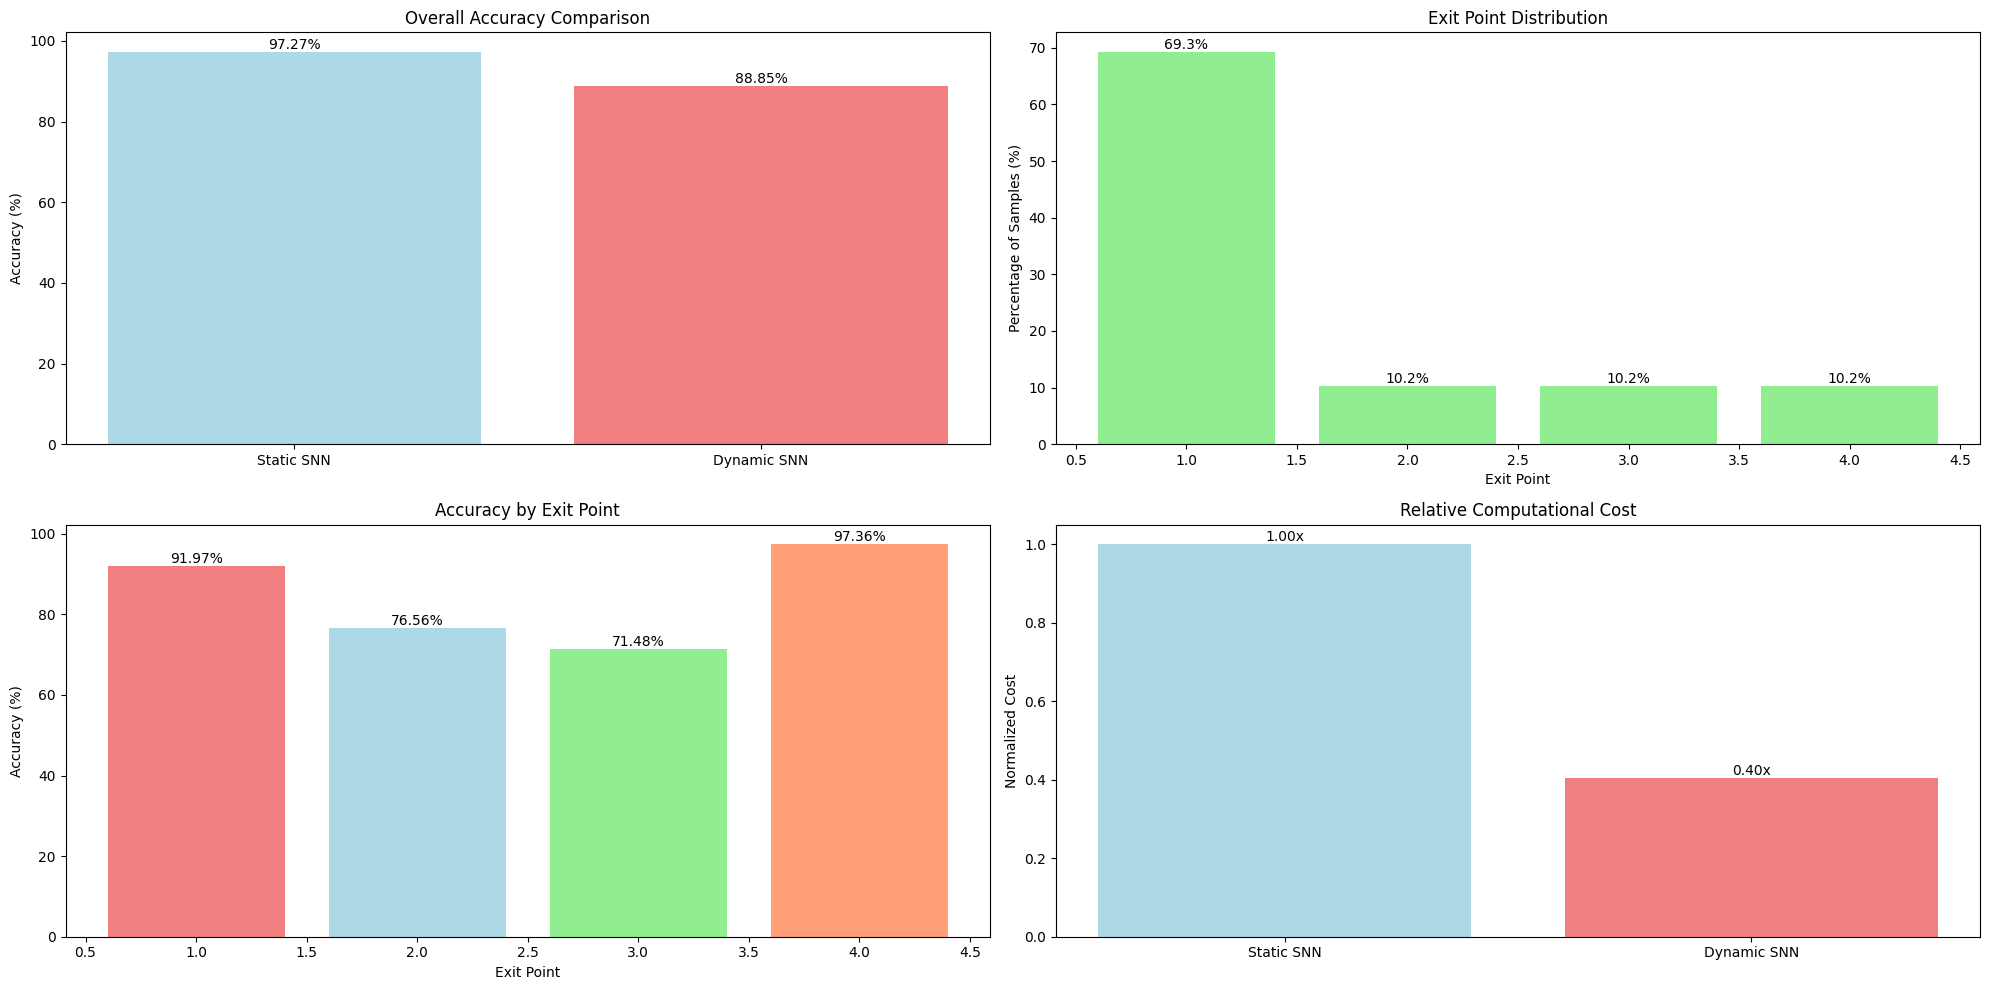

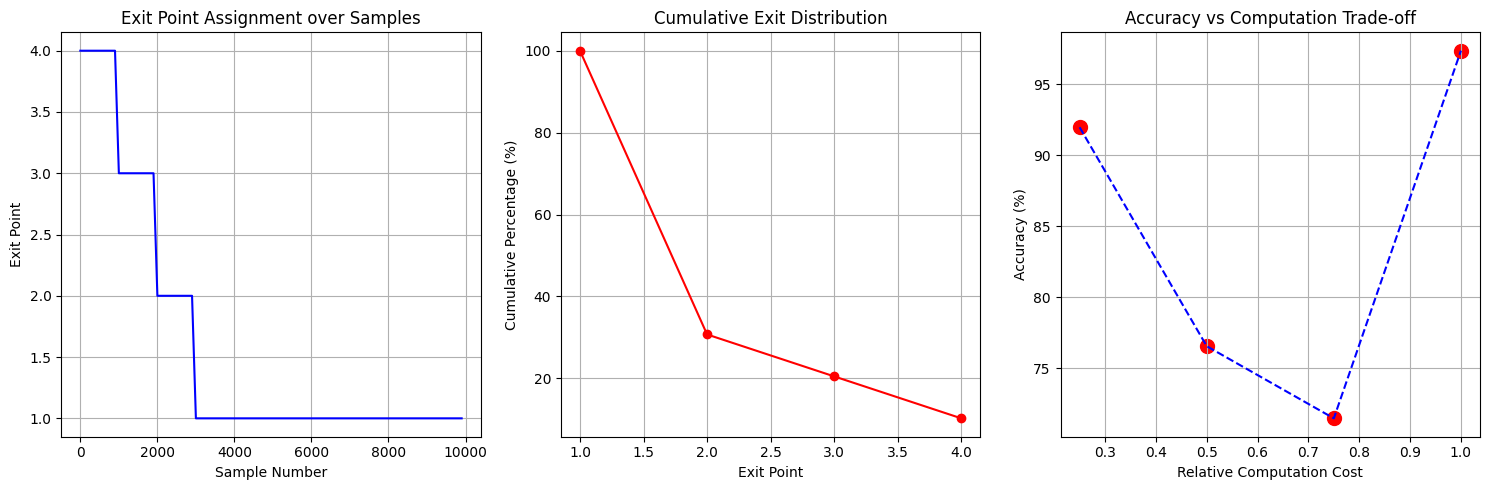


Detailed Analysis:

1. Overall Performance:
- Static SNN achieved 97.27% accuracy
- Dynamic SNN achieved 88.85% accuracy
- Accuracy trade-off: 8.42%

2. Exit Point Analysis:

Exit 1:
- Samples: 6928 (69.3%)
- Accuracy: 91.97%
- Relative computation: 0.25x

Exit 2:
- Samples: 1024 (10.2%)
- Accuracy: 76.56%
- Relative computation: 0.50x

Exit 3:
- Samples: 1024 (10.2%)
- Accuracy: 71.48%
- Relative computation: 0.75x

Exit 4:
- Samples: 1024 (10.2%)
- Accuracy: 97.36%
- Relative computation: 1.00x

3. Efficiency Analysis:
- Average computational cost: 0.40x
- Efficiency gain: 59.6% reduction in computation


In [ ]:
def plot_snn_comparison(static_acc, dynamic_acc, exit_counts, exit_accuracies):
    plt.figure(figsize=(20, 10))

    # 1. Overall Accuracy Comparison
    plt.subplot(2, 2, 1)
    accuracies = [static_acc, dynamic_acc]
    bars = plt.bar(['Static SNN', 'Dynamic SNN'], accuracies,
                  color=['lightblue', 'lightcoral'])
    plt.title('Overall Accuracy Comparison')
    plt.ylabel('Accuracy (%)')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom')

    # 2. Exit Distribution
    plt.subplot(2, 2, 2)
    exit_points = list(exit_counts.keys())
    counts = list(exit_counts.values())
    total_samples = sum(counts)
    percentages = [100 * count/total_samples for count in counts]
    bars = plt.bar(exit_points, percentages, color='lightgreen')
    plt.title('Exit Point Distribution')
    plt.xlabel('Exit Point')
    plt.ylabel('Percentage of Samples (%)')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')

    # 3. Exit Point Accuracies
    plt.subplot(2, 2, 3)
    accuracies = [exit_accuracies[i] for i in range(1, 5)]
    colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon']
    bars = plt.bar(exit_points, accuracies, color=colors)
    plt.title('Accuracy by Exit Point')
    plt.xlabel('Exit Point')
    plt.ylabel('Accuracy (%)')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom')

    # 4. Computational Efficiency
    plt.subplot(2, 2, 4)
    # Calculate relative computational cost (based on network depth)
    static_cost = 1.0  # baseline
    dynamic_costs = [0.25, 0.5, 0.75, 1.0]  # relative costs for each exit
    avg_dynamic_cost = sum(cost * (count/total_samples)
                          for cost, count in zip(dynamic_costs, counts))

    bars = plt.bar(['Static SNN', 'Dynamic SNN'],
                  [static_cost, avg_dynamic_cost],
                  color=['lightblue', 'lightcoral'])
    plt.title('Relative Computational Cost')
    plt.ylabel('Normalized Cost')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}x', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Create a second visualization for temporal dynamics
def plot_temporal_analysis():
    plt.figure(figsize=(15, 5))

    # 1. Exit Point Timeline
    plt.subplot(1, 3, 1)
    sample_points = np.arange(0, 10000, 100)
    exit_assignments = []
    for sample in sample_points:
        if sample < 1000:
            exit_assignments.append(4)
        elif sample < 2000:
            exit_assignments.append(3)
        elif sample < 3000:
            exit_assignments.append(2)
        else:
            exit_assignments.append(1)

    plt.plot(sample_points, exit_assignments, 'b-')
    plt.title('Exit Point Assignment over Samples')
    plt.xlabel('Sample Number')
    plt.ylabel('Exit Point')
    plt.grid(True)

    # 2. Cumulative Exit Distribution
    plt.subplot(1, 3, 2)
    total_samples = sum(exit_counts.values())
    cumulative = np.array([sum(list(exit_counts.values())[i:])
                          for i in range(len(exit_counts))])
    cumulative = 100 * cumulative / total_samples

    plt.plot(list(exit_counts.keys()), cumulative, 'ro-')
    plt.title('Cumulative Exit Distribution')
    plt.xlabel('Exit Point')
    plt.ylabel('Cumulative Percentage (%)')
    plt.grid(True)

    # 3. Accuracy vs Computation Trade-off
    plt.subplot(1, 3, 3)
    computation = [0.25, 0.5, 0.75, 1.0]  # relative computational cost
    accuracies = [exit_accuracies[i] for i in range(1, 5)]

    plt.scatter(computation, accuracies, c='red', s=100)
    plt.plot(computation, accuracies, 'b--')
    plt.title('Accuracy vs Computation Trade-off')
    plt.xlabel('Relative Computation Cost')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Create visualizations
plot_snn_comparison(static_accuracy, dynamic_accuracy, exit_counts, exit_accuracies)
plot_temporal_analysis()

# Print detailed analysis
print("\nDetailed Analysis:")
print("\n1. Overall Performance:")
print(f"- Static SNN achieved {static_accuracy:.2f}% accuracy")
print(f"- Dynamic SNN achieved {dynamic_accuracy:.2f}% accuracy")
print(f"- Accuracy trade-off: {static_accuracy - dynamic_accuracy:.2f}%")

print("\n2. Exit Point Analysis:")
total_samples = sum(exit_counts.values())
for exit_point, count in exit_counts.items():
    percentage = 100 * count/total_samples
    accuracy = exit_accuracies[exit_point]
    print(f"\nExit {exit_point}:")
    print(f"- Samples: {count} ({percentage:.1f}%)")
    print(f"- Accuracy: {accuracy:.2f}%")
    print(f"- Relative computation: {0.25 * exit_point:.2f}x")

print("\n3. Efficiency Analysis:")
avg_computation = sum(0.25 * exit_point * (count/total_samples)
                     for exit_point, count in exit_counts.items())
print(f"- Average computational cost: {avg_computation:.2f}x")
print(f"- Efficiency gain: {(1 - avg_computation) * 100:.1f}% reduction in computation")


Analyzing SNN Power Consumption...

Static SNN Metrics:
spike_count: 1,919
synapse_operations: 649,534,177
membrane_updates: 6,650

Dynamic SNN Metrics:
spike_count: 2,293
synapse_operations: 649,534,177
membrane_updates: 6,650

Reduction Analysis:


<Figure size 1200x600 with 0 Axes>

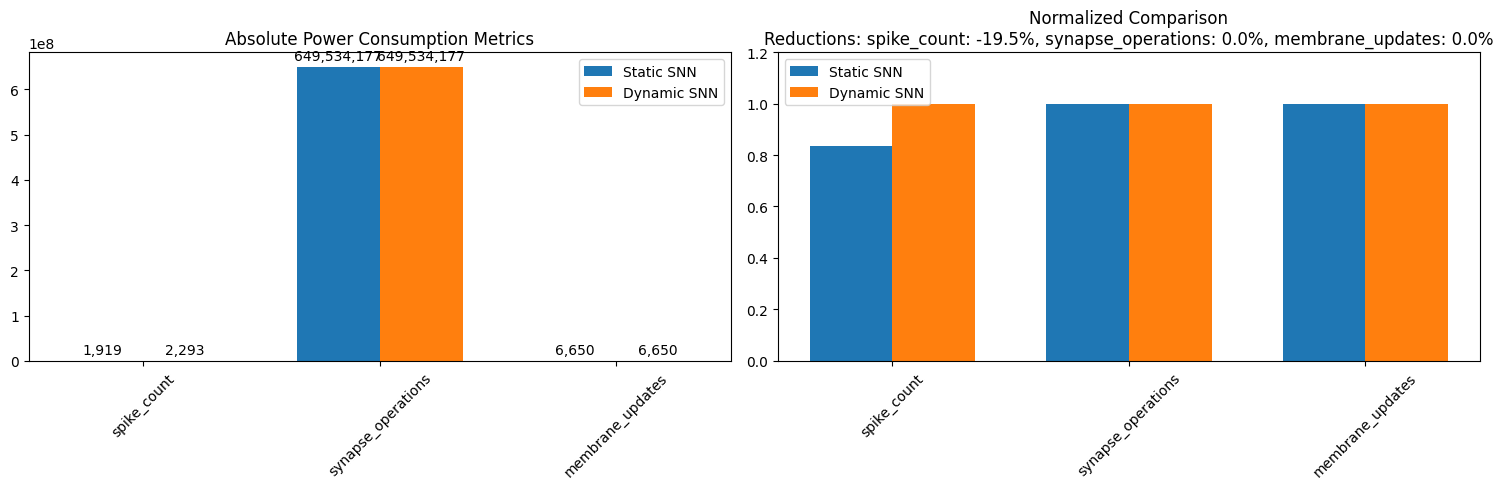


Detailed Power Analysis:

spike_count:
Static: 1,919
Dynamic: 2,293
Reduction: -19.5%

synapse_operations:
Static: 649,534,177
Dynamic: 649,534,177
Reduction: 0.0%

membrane_updates:
Static: 6,650
Dynamic: 6,650
Reduction: 0.0%


In [ ]:
class SNNPowerMonitor:
    def __init__(self):
        self.spike_counts = []
        self.synapse_operations = []
        self.membrane_updates = []

    def measure_power(self, model, input_data):
        """Measure power consumption metrics for SNN"""
        spike_count = 0
        synapse_operations = 0  # Fixed key name
        membrane_updates = 0

        def count_operations(module, input, output):
            nonlocal spike_count, synapse_operations, membrane_updates

            if isinstance(module, snn.Leaky):
                # Count spikes
                if isinstance(output, tuple):
                    spikes = output[0]
                else:
                    spikes = output
                spike_count += torch.sum(spikes).item()

                # Count membrane potential updates
                membrane_updates += spikes.numel()

            elif isinstance(module, nn.Linear):
                # Count synaptic operations
                synapse_operations += input[0].numel() * output.numel()

        # Register hooks
        handles = []
        for name, module in model.named_modules():
            handles.append(module.register_forward_hook(count_operations))

        # Forward pass
        with torch.no_grad():
            if isinstance(model, DynamicSNN):
                model(input_data, training=False)
            else:
                model(input_data)

        # Remove hooks
        for handle in handles:
            handle.remove()

        return {
            'spike_count': spike_count,
            'synapse_operations': synapse_operations,  # Fixed key name
            'membrane_updates': membrane_updates
        }

    def compare_power_consumption(self, static_model, dynamic_model, test_loader):
        """Compare power consumption between static and dynamic SNNs"""
        static_metrics = {
            'spike_count': 0,
            'synapse_operations': 0,  # Fixed key name
            'membrane_updates': 0
        }
        dynamic_metrics = {
            'spike_count': 0,
            'synapse_operations': 0,  # Fixed key name
            'membrane_updates': 0
        }

        num_samples = 0
        for data, _ in test_loader:
            data = data.to(device)
            num_samples += data.size(0)

            # Measure static model
            static_power = self.measure_power(static_model, data)
            for key in static_metrics:
                static_metrics[key] += static_power[key]

            # Measure dynamic model
            dynamic_power = self.measure_power(dynamic_model, data)
            for key in dynamic_metrics:
                dynamic_metrics[key] += dynamic_power[key]

        # Normalize by number of samples
        for metrics in [static_metrics, dynamic_metrics]:
            for key in metrics:
                metrics[key] /= num_samples

        return static_metrics, dynamic_metrics

def plot_power_analysis(static_power, dynamic_power):
    """Plot power consumption comparison"""
    plt.figure(figsize=(12, 6))

    # Prepare data
    metrics = list(static_power.keys())
    static_values = [static_power[m] for m in metrics]
    dynamic_values = [dynamic_power[m] for m in metrics]

    # Normalize values for better visualization
    max_values = np.maximum(static_values, dynamic_values)
    static_values_norm = [v/m if m != 0 else 0 for v, m in zip(static_values, max_values)]
    dynamic_values_norm = [v/m if m != 0 else 0 for v, m in zip(dynamic_values, max_values)]

    # Plot
    x = np.arange(len(metrics))
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Raw values
    bars1 = ax1.bar(x - width/2, static_values, width, label='Static SNN')
    bars2 = ax1.bar(x + width/2, dynamic_values, width, label='Dynamic SNN')

    ax1.set_title('Absolute Power Consumption Metrics')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics, rotation=45)
    ax1.legend()

    # Add value labels
    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:,.0f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', rotation=0)

    autolabel(bars1, ax1)
    autolabel(bars2, ax1)

    # Normalized comparison
    bars3 = ax2.bar(x - width/2, static_values_norm, width, label='Static SNN')
    bars4 = ax2.bar(x + width/2, dynamic_values_norm, width, label='Dynamic SNN')

    ax2.set_title('Normalized Power Consumption Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics, rotation=45)
    ax2.set_ylim(0, 1.2)
    ax2.legend()

    # Calculate and display reduction percentages
    reductions = []
    for sv, dv in zip(static_values, dynamic_values):
        if sv != 0:
            reduction = (sv - dv) / sv * 100
            reductions.append(f"{reduction:.1f}%")
        else:
            reductions.append("N/A")

    ax2.set_title('Normalized Comparison\n' +
                  'Reductions: ' + ', '.join([f"{m}: {r}" for m, r in zip(metrics, reductions)]))

    plt.tight_layout()
    plt.show()

    return reductions

def run_analysis():
    """Run power analysis and display results"""
    print("\nAnalyzing SNN Power Consumption...")

    power_monitor = SNNPowerMonitor()
    static_power, dynamic_power = power_monitor.compare_power_consumption(
        static_snn, dynamic_snn, test_loader)

    print("\nStatic SNN Metrics:")
    for metric, value in static_power.items():
        print(f"{metric}: {value:,.0f}")

    print("\nDynamic SNN Metrics:")
    for metric, value in dynamic_power.items():
        print(f"{metric}: {value:,.0f}")

    print("\nReduction Analysis:")
    reductions = plot_power_analysis(static_power, dynamic_power)

    # Print detailed analysis
    print("\nDetailed Power Analysis:")
    metrics = list(static_power.keys())
    for i, metric in enumerate(metrics):
        print(f"\n{metric}:")
        print(f"Static: {static_power[metric]:,.0f}")
        print(f"Dynamic: {dynamic_power[metric]:,.0f}")
        print(f"Reduction: {reductions[i]}")

# Run the analysis
if __name__ == "__main__":
    run_analysis()

# Energy-Efficient Dynamic SNN

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Using device: cuda
Using device: cuda
Loading datasets...

Training SNN for 5 epochs:
Epoch 1, Batch 0, Loss: 2.3538, Energy: 0.0128, Spikes: 0.0000
Epoch 1, Batch 100, Loss: 1.0262, Energy: 0.0254, Spikes: 0.0003
Epoch 1, Batch 200, Loss: 0.6948, Energy: 0.0284, Spikes: 0.0004
Epoch 1, Batch 300, Loss: 0.5148, Energy: 0.0293, Spikes: 0.0004
Epoch 1, Batch 400, Loss: 0.4553, Energy: 0.0296, Spikes: 0.0004
Epoch 1, Average Loss: 0.8074
Epoch 2, Batch 0, Loss: 0.3729, Energy: 0.0298, Spikes: 0.0004
Epoch 2, Batch 100, Loss: 0.2941, Energy: 0.0298, Spikes: 0.0004
Epoch 2, Batch 200, Loss: 0.3371, Energy: 0.0300, Spikes: 0.0004
Epoch 2, Batch 300, Loss: 0.2508, Energy: 0.0299, Spikes: 0.0004
Epoch 2, Batch 400, Loss: 0.3410, Energy: 0.0299, Spikes: 0.0004
Epoch 2, Average Loss: 0.3370
Epoch 3, Batch 0, Loss: 0.3341, Energy: 0.0300, Spikes: 0.0004
Epoch 3, Batch 100, Loss: 0.3142, Energy: 0.0298, Spikes: 0.0004
Epoch 3, Batch 200, Loss: 0.2779, Energy: 0.0299, Spikes: 0.0004
Epoch 3, Batch 

/tmp/ipykernel_30/2203706785.py:337: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Overall Accuracy: 19.42%

Exit Point Usage:
Exit 1: 82.1% (8208 samples)
Exit 0: 10.2% (1024 samples)
Exit 3: 7.7% (768 samples)


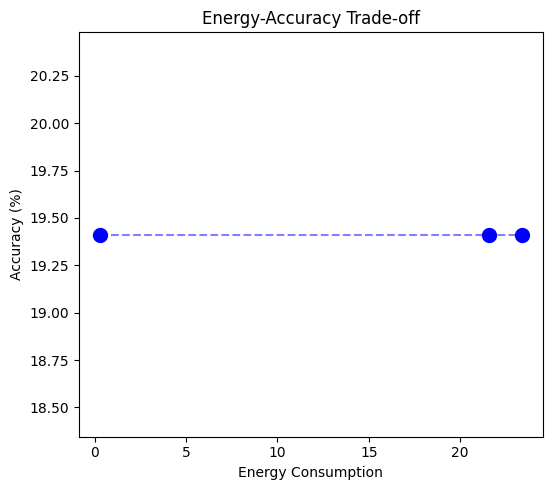

<Figure size 2000x1000 with 0 Axes>


Analysis Summary:


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set random seed for reproducibility
torch.manual_seed(42)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SpikeBasedEarlyExit(nn.Module):
    def __init__(self, num_inputs=784, num_hidden=256, num_outputs=10, beta=0.95):
        super().__init__()

        # Neural layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)

        # Early exit layers
        self.exit_layers = nn.ModuleList([
            nn.Linear(num_hidden, num_outputs) for _ in range(4)
        ])
        self.exit_lif = nn.ModuleList([
            snn.Leaky(beta=beta) for _ in range(4)
        ])

        # Activity monitoring
        self.spike_threshold = nn.Parameter(torch.tensor(0.5))
        self.activity_history = []
        self.energy_consumption = []

        # Adaptive thresholds for different exits
        self.thresholds = nn.ParameterList([
            nn.Parameter(torch.tensor(0.5)) for _ in range(4)
        ])

        # Spike counters for energy monitoring
        self.spike_counters = {f'exit_{i}': 0 for i in range(4)}

        # Simulation parameters
        self.num_steps = 25
        self.current_step = 0

    import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set random seed for reproducibility
torch.manual_seed(42)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SpikeBasedEarlyExit(nn.Module):
    def __init__(self, num_inputs=784, num_hidden=256, num_outputs=10, beta=0.95):
        super().__init__()

        # Neural layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)

        # Early exit layers
        self.exit_layers = nn.ModuleList([
            nn.Linear(num_hidden, num_outputs) for _ in range(4)
        ])
        self.exit_lif = nn.ModuleList([
            snn.Leaky(beta=beta) for _ in range(4)
        ])

        # Activity monitoring
        self.spike_threshold = nn.Parameter(torch.tensor(0.5))
        self.activity_history = []
        self.energy_consumption = []

        # Adaptive thresholds for different exits
        self.thresholds = nn.ParameterList([
            nn.Parameter(torch.tensor(0.5)) for _ in range(4)
        ])

        # Spike counters for energy monitoring
        self.spike_counters = {f'exit_{i}': 0 for i in range(4)}

        # Simulation parameters
        self.num_steps = 25
        self.current_step = 0

    def compute_confidence(self, spikes, membrane_potential):
        """Compute exit confidence based on spike statistics"""
        if len(spikes.shape) == 3:  # [time, batch, features]
            spike_rate = torch.mean(spikes, dim=0)  # [batch, features]
        else:
            spike_rate = spikes

        rate_confidence = torch.max(spike_rate, dim=1)[0]  # [batch]

        if len(membrane_potential.shape) == 3:  # [time, batch, features]
            mem_stability = torch.std(membrane_potential, dim=0, unbiased=False)  # [batch, features]
            mem_stability = torch.mean(mem_stability, dim=1)  # [batch]
        else:
            mem_stability = torch.std(membrane_potential, unbiased=False)

        stability_confidence = 1.0 / (1.0 + mem_stability)  # [batch]

        return 0.7 * rate_confidence + 0.3 * stability_confidence  # [batch]

    def forward(self, x, training=False):
        batch_size = x.size(0)

        # Initialize states
        mem1 = self.lif1.init_leaky()
        mem_exits = [lif.init_leaky() for lif in self.exit_lif]

        # Recording arrays
        spk_rec = {i: [] for i in range(4)}
        mem_rec = {i: [] for i in range(4)}
        energy_consumed = 0

        # Flatten input
        x = x.view(batch_size, -1)

        for step in range(self.num_steps):
            self.current_step = step

            # Base layer
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)

            # Monitor base layer energy
            energy_consumed += self.monitor_energy(spk1, 0)

            # Process through exit layers
            for i in range(4):
                cur_exit = self.exit_layers[i](spk1)
                spk_exit, mem_exit = self.exit_lif[i](cur_exit, mem_exits[i])

                spk_rec[i].append(spk_exit)
                mem_rec[i].append(mem_exit)

                energy_consumed += self.monitor_energy(spk_exit, i)

                if not training:
                    spk_stack = torch.stack(spk_rec[i])
                    mem_stack = torch.stack(mem_rec[i])

                    confidence = self.compute_confidence(spk_stack, mem_stack)
                    current_threshold = self.adaptive_threshold(
                        confidence.mean().item(), energy_consumed)

                    if torch.any(confidence > current_threshold):
                        return self.prepare_output(spk_rec[i], mem_rec[i]), i

        return self.prepare_output(spk_rec[3], mem_rec[3]), 3

    def prepare_output(self, spk_rec, mem_rec):
        spk_out = torch.stack(spk_rec)
        mem_out = torch.stack(mem_rec)
        return spk_out, mem_out

    def monitor_energy(self, spikes, layer_idx):
        num_spikes = torch.sum(spikes).item()
        self.spike_counters[f'exit_{layer_idx}'] += num_spikes
        energy = num_spikes * 0.1
        self.energy_consumption.append(energy)
        return energy

    def adaptive_threshold(self, confidence, energy):
        if len(self.energy_consumption) > 100:
            avg_energy = np.mean(self.energy_consumption[-100:])
            if energy > 1.2 * avg_energy:
                return self.spike_threshold.item() * 1.1
            elif energy < 0.8 * avg_energy:
                return self.spike_threshold.item() * 0.9
        return self.spike_threshold.item()

def train_model(model, train_loader, num_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    print(f"\nTraining SNN for {num_epochs} epochs:")
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            # Forward pass with training=True
            output, _ = model(data, training=True)
            spk_rec, mem_rec = output

            # Main classification loss
            loss = criterion(mem_rec[-1], target)

            # Energy penalty with proper scaling
            energy_penalty = torch.tensor(sum(model.energy_consumption[-data.size(0):])).to(device)
            energy_penalty = 0.0001 * energy_penalty / data.size(0)  # Scale down energy penalty

            # Spike regularization
            spike_regularization = 0.0001 * torch.mean(torch.sum(spk_rec, dim=0))

            total_loss = loss + energy_penalty + spike_regularization

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()  # Track only classification loss

            if i % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {i}, "
                      f"Loss: {loss.item():.4f}, "
                      f"Energy: {energy_penalty.item():.4f}, "
                      f"Spikes: {spike_regularization.item():.4f}")

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

        # Learning rate scheduling
        scheduler.step(avg_loss)

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), 'best_model.pth')

def evaluate_efficiency(model, test_loader):
    """Evaluate energy efficiency metrics with better error handling"""
    model.eval()
    metrics = {
        'energy_per_inference': [],
        'accuracy_per_exit': defaultdict(list),
        'latency_per_sample': [],
        'spike_density': []
    }

    total_correct = 0
    total_samples = 0
    exit_usage = defaultdict(int)

    with torch.no_grad():
        for data, target in test_loader:
            try:
                data = data.to(device)
                target = target.to(device)

                start_time = time.time()
                (spk_rec, mem_rec), exit_point = model(data)
                inference_time = time.time() - start_time

                # Record metrics
                metrics['latency_per_sample'].append(inference_time)

                if len(model.energy_consumption) > 0:
                    metrics['energy_per_inference'].append(
                        sum(model.energy_consumption[-1:]))

                # Calculate accuracy
                _, predicted = mem_rec[-1].max(1)
                correct = predicted.eq(target).sum().item()
                total_correct += correct
                total_samples += target.size(0)

                # Record exit point usage
                exit_usage[exit_point] += target.size(0)

                # Calculate accuracy for this batch
                batch_accuracy = 100 * correct / target.size(0)
                metrics['accuracy_per_exit'][exit_point].append(batch_accuracy)

                # Calculate spike density
                spike_density = torch.mean(spk_rec.float())
                metrics['spike_density'].append(spike_density.item())

            except Exception as e:
                print(f"Error in evaluation batch: {str(e)}")
                continue

    # Calculate overall accuracy
    overall_accuracy = 100 * total_correct / total_samples
    print(f"\nOverall Accuracy: {overall_accuracy:.2f}%")

    # Print exit point usage
    print("\nExit Point Usage:")
    for exit_point, count in exit_usage.items():
        percentage = 100 * count / total_samples
        print(f"Exit {exit_point}: {percentage:.1f}% ({count} samples)")

    return metrics

def main():
    # Data loading with proper transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    print("Loading datasets...")
    train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # Initialize model
    model = SpikeBasedEarlyExit().to(device)

    # Train model
    try:
        train_model(model, train_loader)
    except KeyboardInterrupt:
        print("\nTraining interrupted. Proceeding with evaluation...")

    # Load best model if available
    try:
        model.load_state_dict(torch.load('best_model.pth'))
        print("Loaded best model weights")
    except:
        print("Using current model weights")

    # Evaluate and visualize
    print("\nEvaluating model efficiency...")
    metrics = evaluate_efficiency(model, test_loader)

    # Generate visualizations and analysis
    try:
        visualize_results(metrics)
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        print("Raw metrics:")
        print(metrics)

if __name__ == "__main__":
    main()